In [2]:
# import sys 
# !{sys.executable} -m pip install matplotlib

In [3]:
import pandas as pd
import numpy as np
from keras import layers
from keras import models
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath
import warnings
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from utils_cm import plot_confusion_matrix
import matplotlib.pyplot as plt
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 100
# the number of features (from the data)
NUMBER_FEATURES = 202
# the number of classes/gestures
NUMBER_OUTPUTS = 2
# you can encode more than 1 but for this example we have binary output (circle/swipe)

In [5]:
# the directory where your data is
mypath = './data'

# creating a list with all the filenames
datafiles = [f for f in listdir('data') if isfile(join(mypath, f))]

In [6]:
# choose data we need
columns = ['handPalmPosition_X','handPalmPosition_Y','handPalmPosition_Z',
          'pitch', 'roll', 'yaw',
          'wristPosition_X', 'wristPosition_Y','wristPosition_Z',
          'elbowPosition_X', 'elbowPosition_Y', 'elbowPosition_Z']

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
bone_names = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
    
for finger in finger_names:
    columns.append(finger + 'Length')
    columns.append(finger + 'Width')

for finger in finger_names:
    for bone in bone_names:
        columns.append(finger + bone + 'Start_X')
        columns.append(finger + bone + 'Start_Y')
        columns.append(finger + bone + 'Start_Z')
        columns.append(finger + bone + 'End_X')
        columns.append(finger + bone + 'End_Y')
        columns.append(finger + bone + 'End_Z')
        columns.append(finger + bone + 'Direction_X') 
        columns.append(finger + bone + 'Direction_Y') 
        columns.append(finger + bone + 'Direction_Z')   

In [7]:
# Features
x = []
# Labels
y = []

for sample in datafiles:
    relative_path = 'data\\' + sample
    tmp = pd.read_csv(relative_path, usecols=columns)
    
    # Normalize the sample size: LSTM requires all inputs of the same size!
    print('{}\nsize raw = {}'.format(relative_path,tmp.shape))
    while tmp.shape[0] < NUMBER_TIMESTEPS:
        tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)

    if tmp.shape[0] > NUMBER_TIMESTEPS:
        tmp = tmp.head(100)
    print('size normalized = ',tmp.shape)
    
    tmp_x = tmp[[column for column in list(tmp.columns)]]
#                  if column != 'GestureTypeCircle' 
#                  and column != 'GestureTypeSwipe']]
    
    # subject 1 --> tmp_y = [1, 0]
    tmp_y = [1,  0]
    if '2c' in sample or '2s' in sample:
        # subject 2 --> tmp_y = [0, 1]
        print('file:2')
        tmp_y = [0, 1]  
        
    x.append(tmp_x)
    y.append(tmp_y)

data\1c1.csv
size raw = (28, 202)
size normalized =  (100, 202)
data\1c10.csv
size raw = (23, 202)
size normalized =  (100, 202)
data\1c2.csv
size raw = (15, 202)
size normalized =  (100, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

data\1c3.csv
size raw = (13, 202)
size normalized =  (100, 202)
data\1c4.csv
size raw = (18, 202)
size normalized =  (100, 202)
data\1c5.csv
size raw = (25, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

size normalized =  (100, 202)
data\1c6.csv
size raw = (18, 202)
size normalized =  (100, 202)
data\1c7.csv
size raw = (24, 202)
size normalized =  (100, 202)
data\1c8.csv
size raw = (19, 202)
size normalized =  (100, 202)
data\1c9.csv
size raw = (48, 202)
size normalized =  (100, 202)
data\1s1.csv
size raw = (33, 202)
size normalized =  (100, 202)
data\1s10.csv
size raw = (24, 202)
size normalized =  (100, 202)
data\1s2.csv
size raw = (20, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

size normalized =  (100, 202)
data\1s3.csv
size raw = (22, 202)
size normalized =  (100, 202)
data\1s4.csv
size raw = (21, 202)
size normalized =  (100, 202)
data\1s5.csv
size raw = (18, 202)
size normalized =  (100, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

data\1s6.csv
size raw = (18, 202)
size normalized =  (100, 202)
data\1s7.csv
size raw = (29, 202)
size normalized =  (100, 202)
data\1s8.csv
size raw = (12, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

size normalized =  (100, 202)
data\1s9.csv
size raw = (19, 202)
size normalized =  (100, 202)
data\2c1.csv
size raw = (27, 202)
size normalized =  (100, 202)
file:2
data\2c10.csv
size raw = (35, 202)
size normalized =  (100, 202)
file:2
data\2c2.csv
size raw = (21, 202)
size normalized =  (100, 202)
file:2
data\2c3.csv
size raw = (24, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

size normalized =  (100, 202)
file:2
data\2c4.csv
size raw = (27, 202)
size normalized =  (100, 202)
file:2
data\2c5.csv
size raw = (26, 202)
size normalized =  (100, 202)
file:2
data\2c6.csv
size raw = (26, 202)
size normalized =  (100, 202)
file:2
data\2c7.csv
size raw = (29, 202)
size normalized =  (100, 202)
file:2
data\2c8.csv
size raw = (20, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

size normalized =  (100, 202)
file:2
data\2c9.csv
size raw = (25, 202)
size normalized =  (100, 202)
file:2
data\2s1.csv
size raw = (29, 202)
size normalized =  (100, 202)
file:2


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

data\2s10.csv
size raw = (30, 202)
size normalized =  (100, 202)
file:2
data\2s2.csv
size raw = (27, 202)
size normalized =  (100, 202)
file:2
data\2s3.csv
size raw = (17, 202)
size normalized =  (100, 202)
file:2


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

data\2s4.csv
size raw = (21, 202)
size normalized =  (100, 202)
file:2
data\2s5.csv
size raw = (25, 202)
size normalized =  (100, 202)
file:2
data\2s6.csv
size raw = (24, 202)


C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
C:\Users\getab\AppData\Local\Temp\ipykernel_27368\1215994032.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

size normalized =  (100, 202)
file:2
data\2s7.csv
size raw = (30, 202)
size normalized =  (100, 202)
file:2
data\2s8.csv
size raw = (29, 202)
size normalized =  (100, 202)
file:2
data\2s9.csv
size raw = (20, 202)
size normalized =  (100, 202)
file:2


In [8]:
print(y)
#np.array(y[0].loc[0])

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]


In [9]:
# Each sample requires labels of [1,NUMBER_OUTPUTS] size (not a list)
y_new = list()
for cur_label in y:
    tmp = np.array(cur_label[0])
    y_new.append(tmp)
y = np.array(y_new)
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [10]:
# Set a percentage of test set fraction
test_percent = 0.20 # 30%

# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_percent, shuffle=True)
len_train = len(X_train)
len_test = len(X_test)

print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))
print ('There is ',type(X_train),' of ',type(X_train[0]))

# Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
X_train = np.array(X_train)
X_test = np.array(X_test)
print('The list was turned into <numpy.ndarray>')

Number of train samples = 32
Number of test samples = 8
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>


In [11]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

----Kernel: linear, C: 1, gamma: 0.1 ----
Total number of matches: 8
Match rate: 1.00


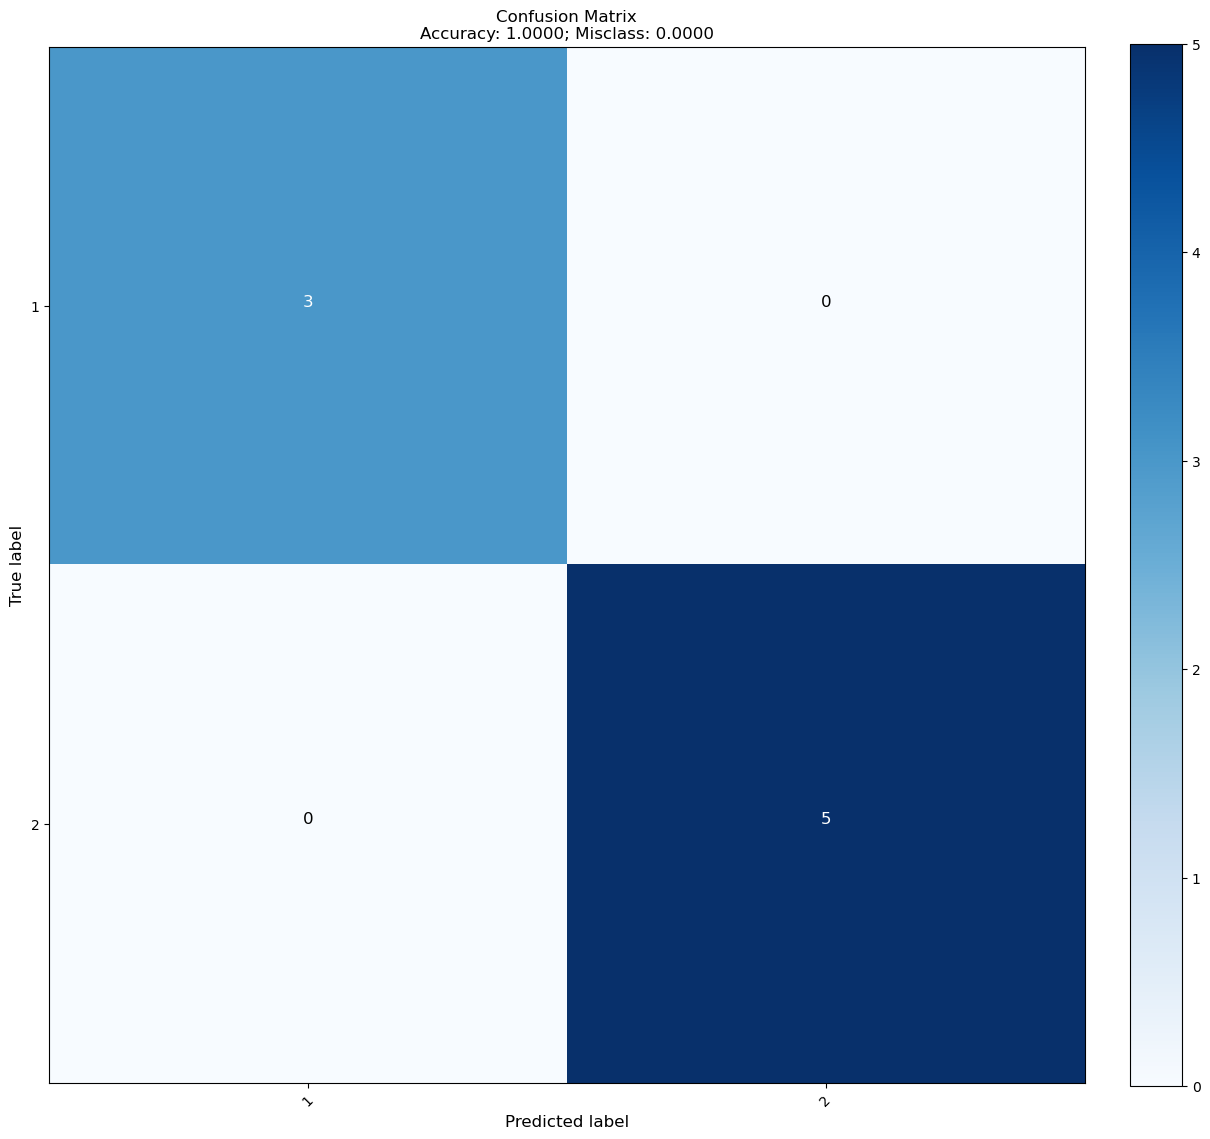

----Kernel: linear, C: 1, gamma: 0.01 ----
Total number of matches: 8
Match rate: 1.00


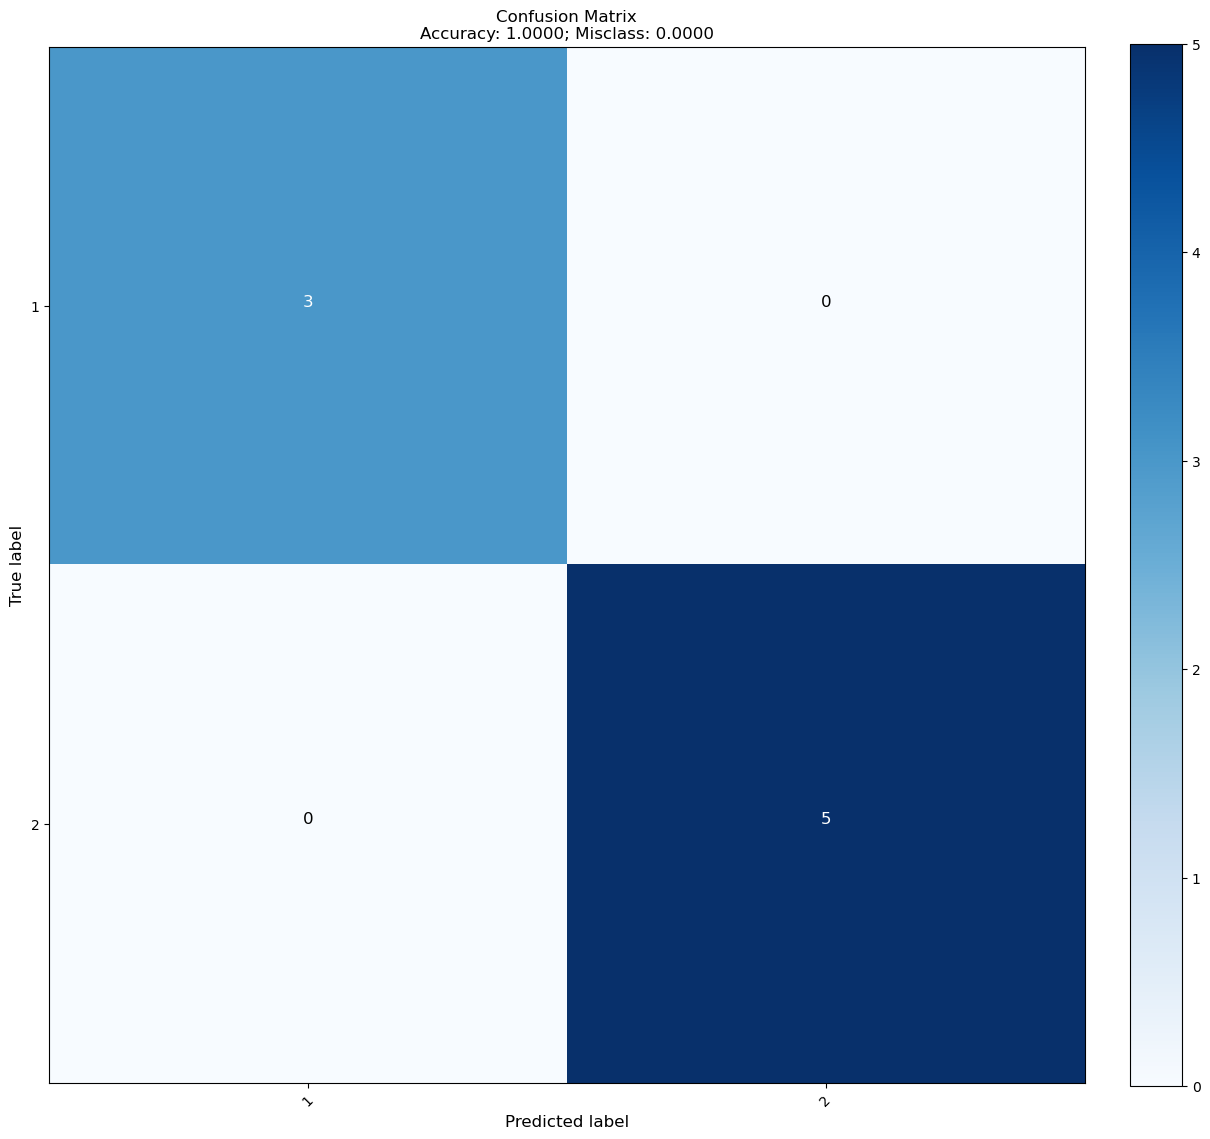

----Kernel: linear, C: 1, gamma: 0.001 ----
Total number of matches: 8
Match rate: 1.00


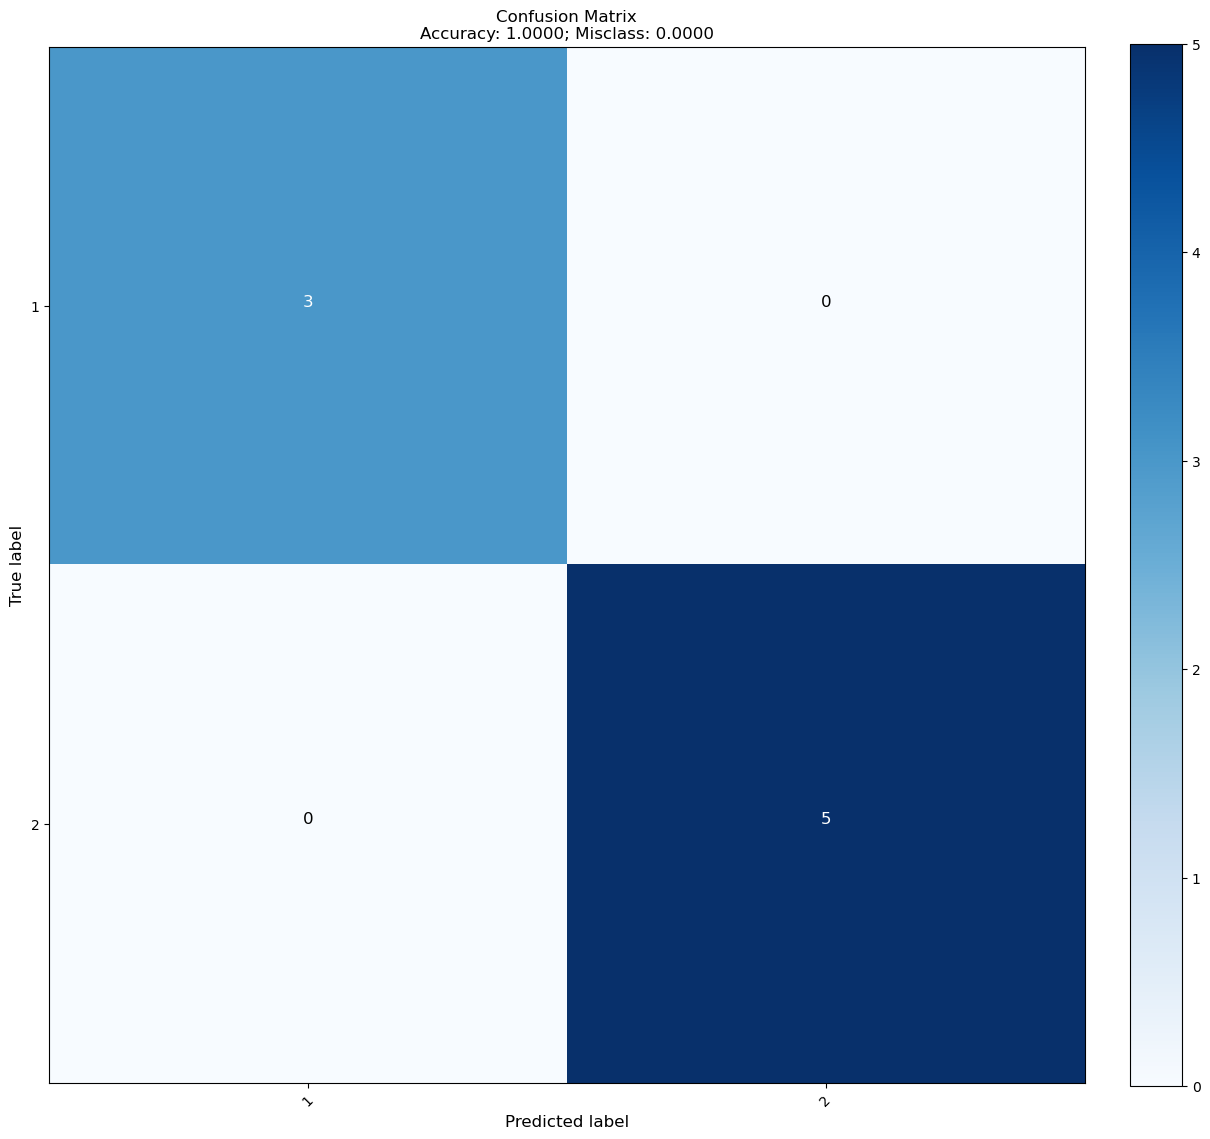

----Kernel: linear, C: 10, gamma: 0.1 ----
Total number of matches: 8
Match rate: 1.00


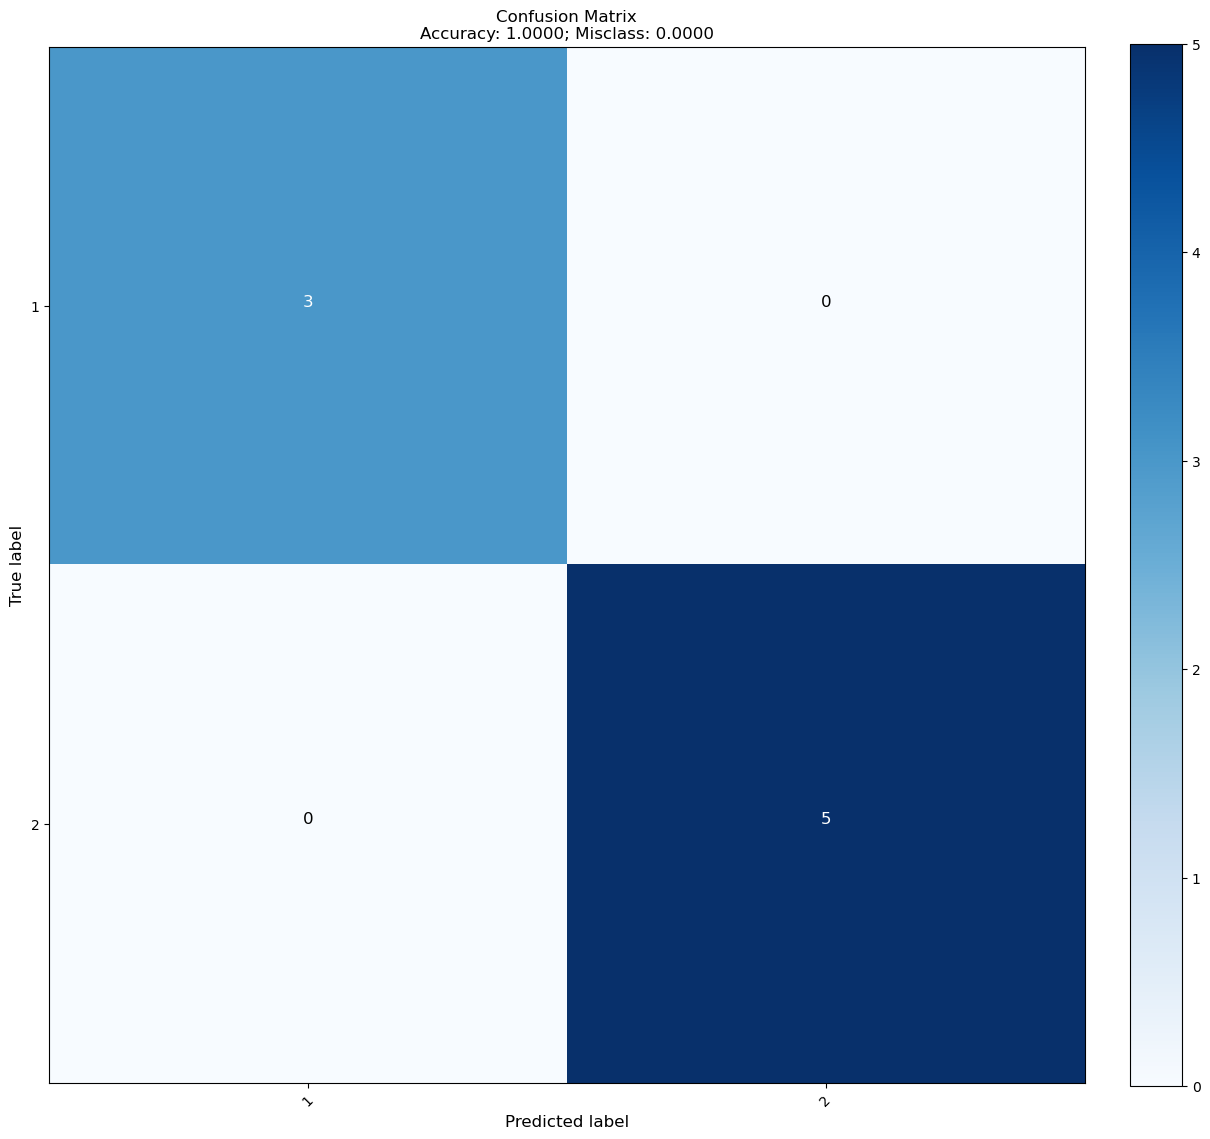

----Kernel: linear, C: 10, gamma: 0.01 ----
Total number of matches: 8
Match rate: 1.00


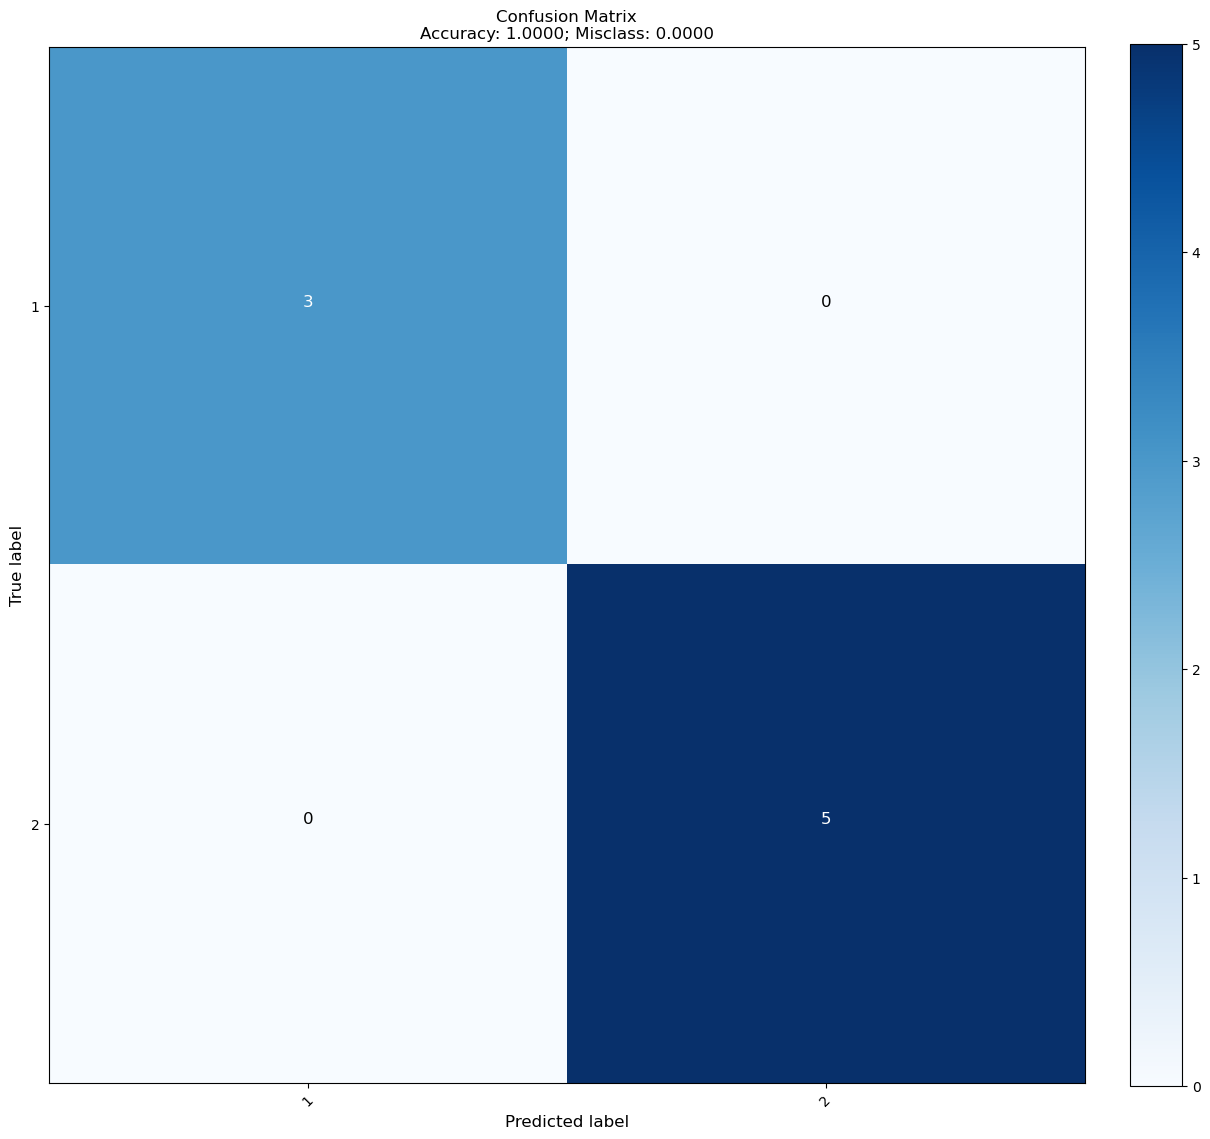

----Kernel: linear, C: 10, gamma: 0.001 ----
Total number of matches: 8
Match rate: 1.00


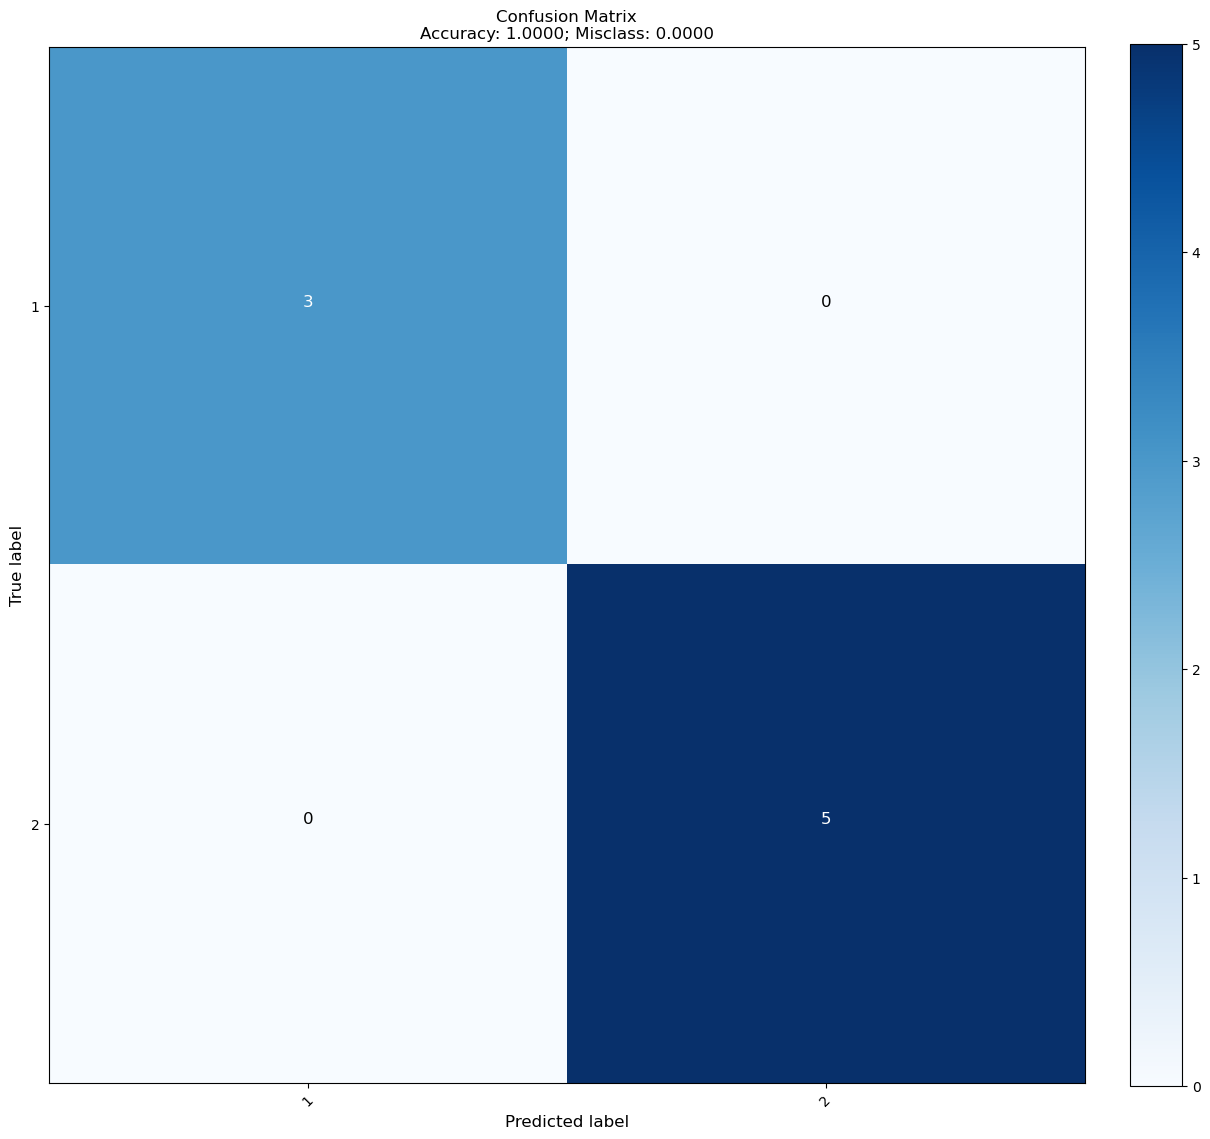

----Kernel: linear, C: 100, gamma: 0.1 ----
Total number of matches: 8
Match rate: 1.00


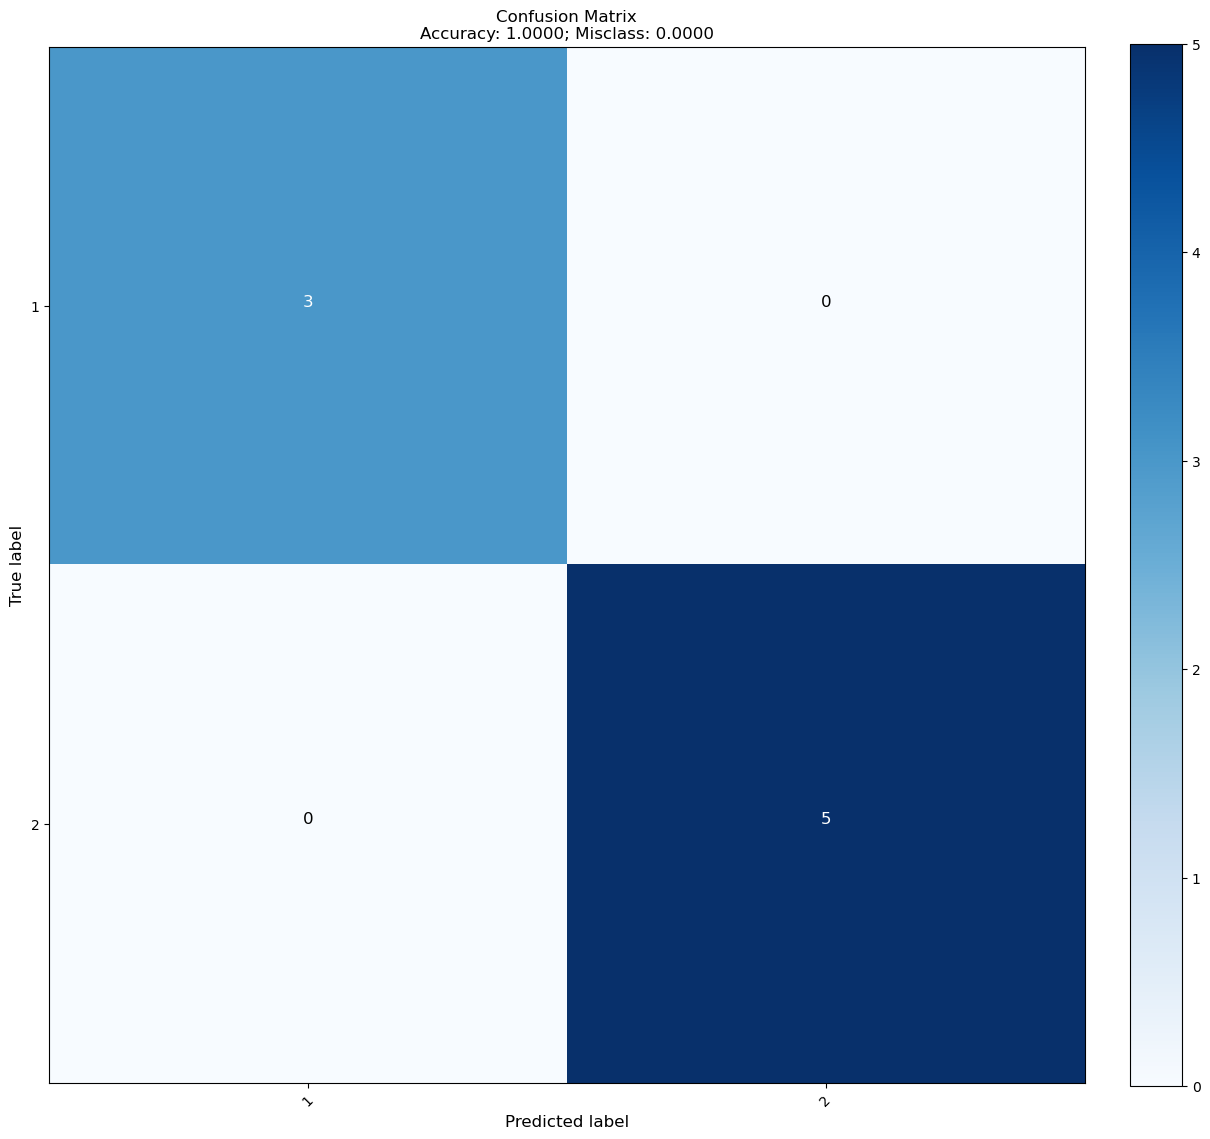

----Kernel: linear, C: 100, gamma: 0.01 ----
Total number of matches: 8
Match rate: 1.00


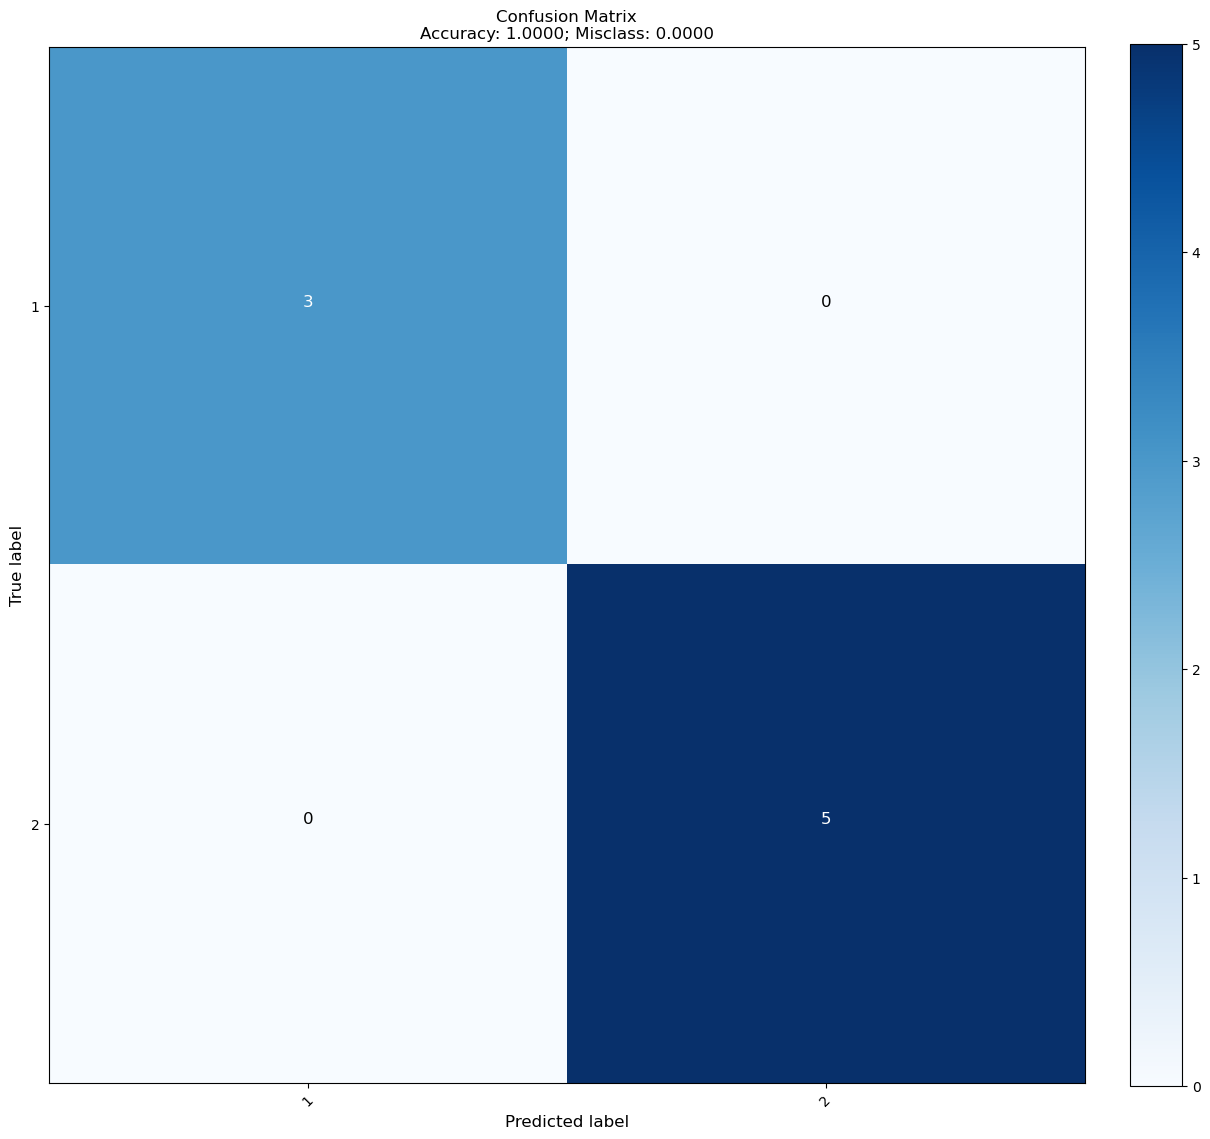

----Kernel: linear, C: 100, gamma: 0.001 ----
Total number of matches: 8
Match rate: 1.00


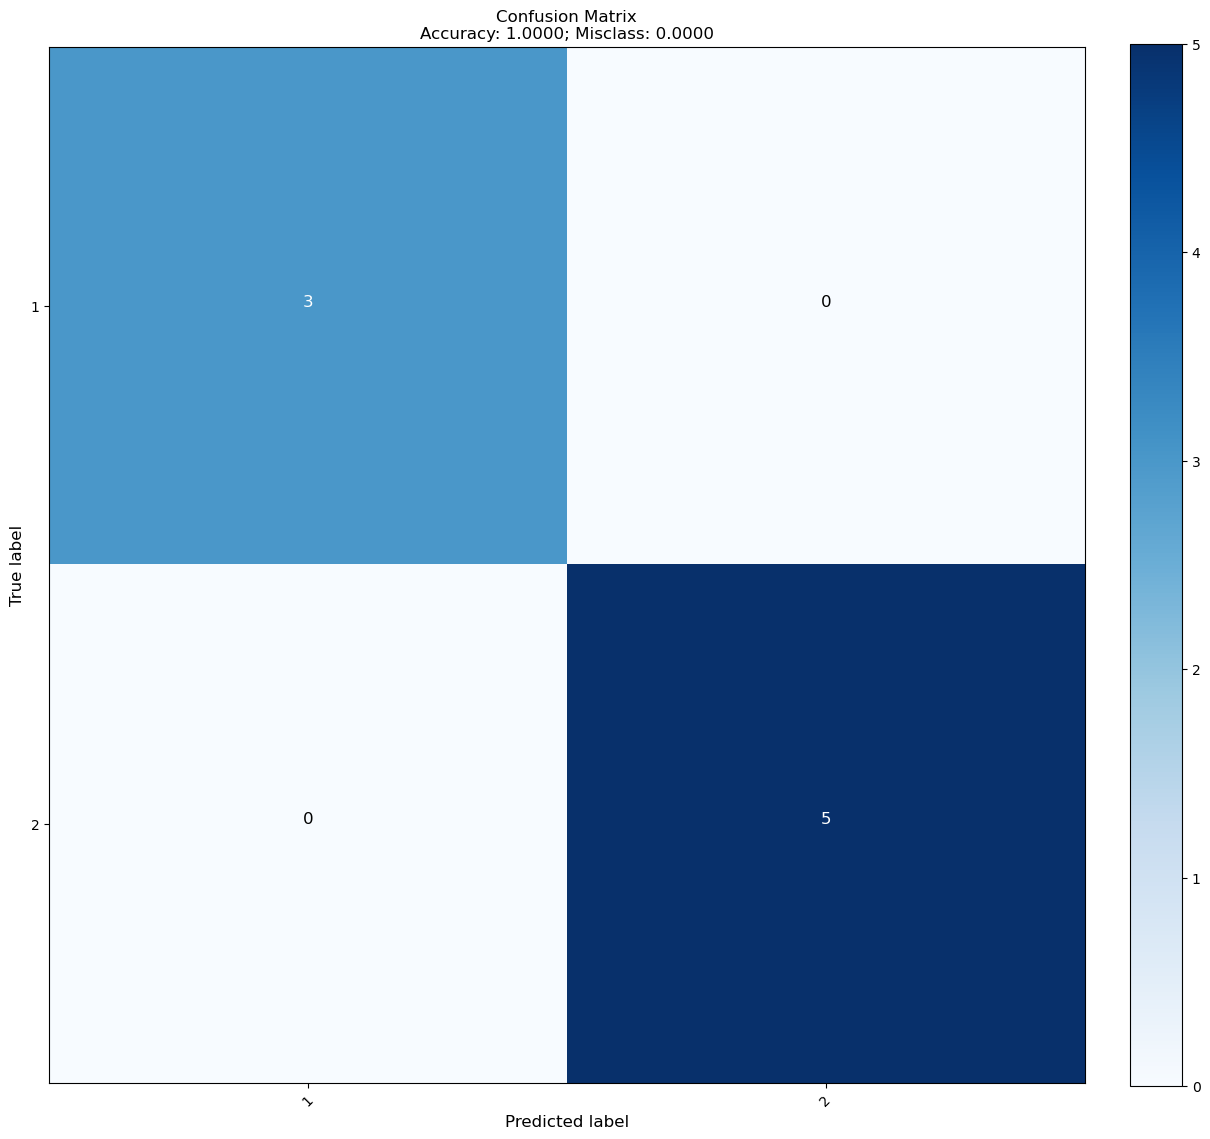

----Kernel: rbf, C: 1, gamma: 0.1 ----
Total number of matches: 8
Match rate: 1.00


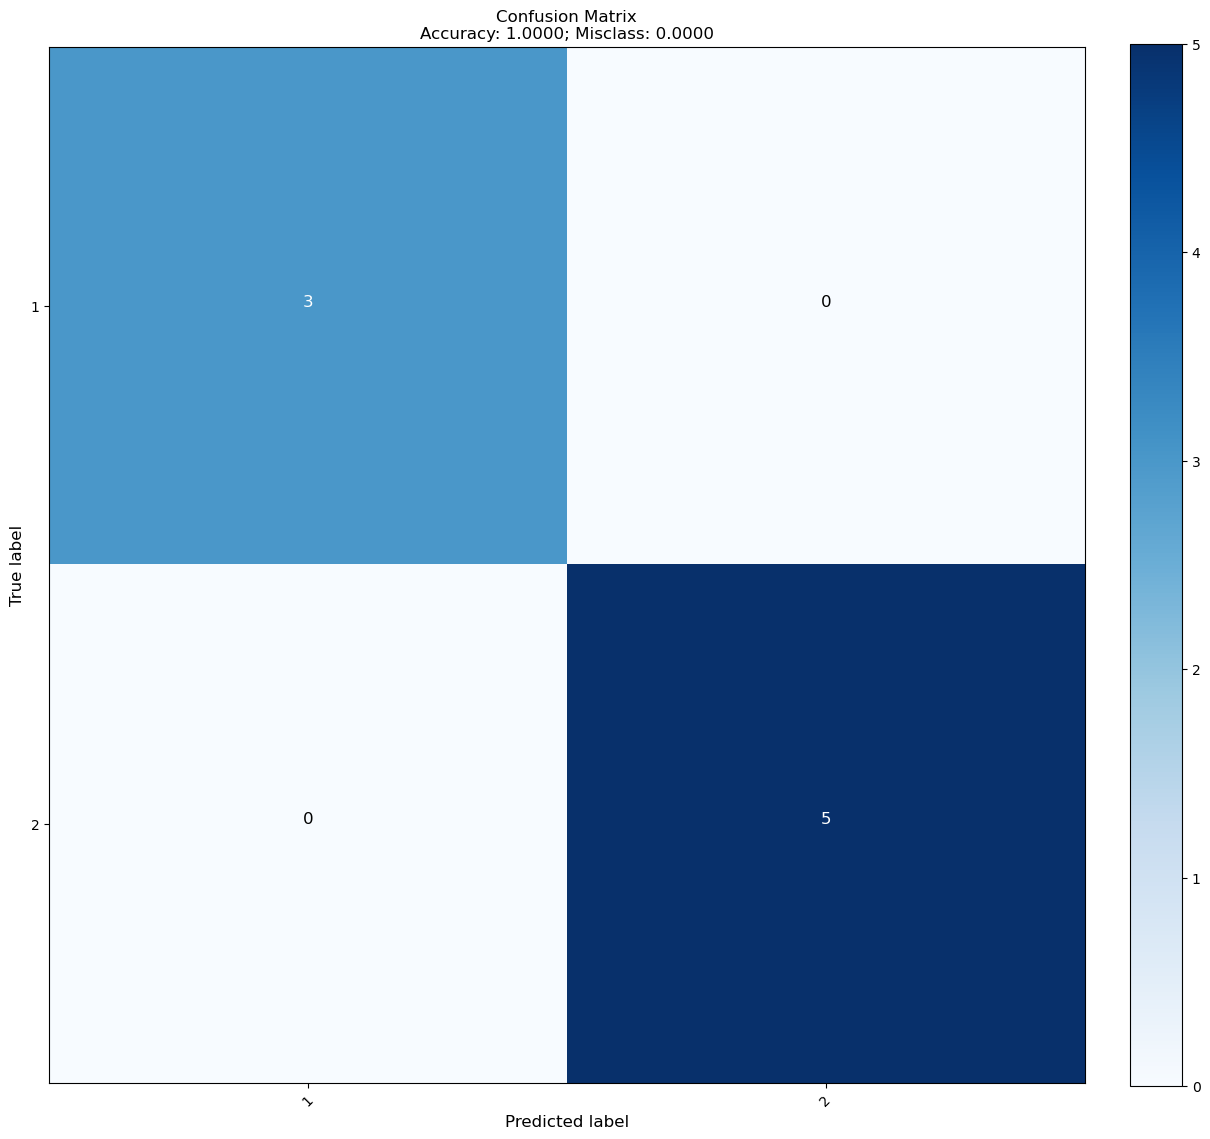

----Kernel: rbf, C: 1, gamma: 0.01 ----
Total number of matches: 8
Match rate: 1.00


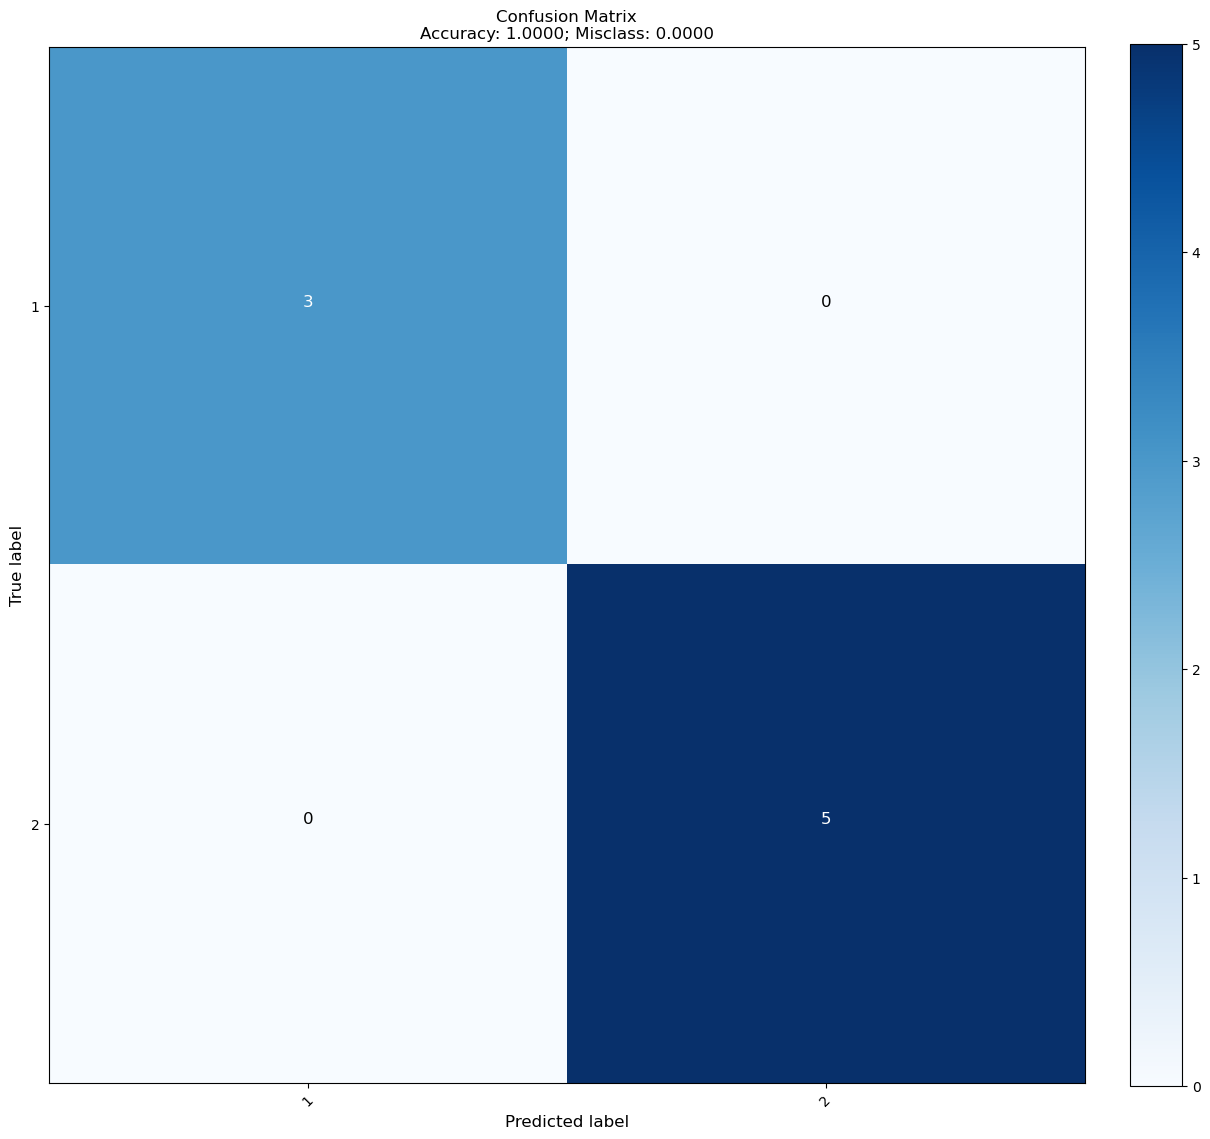

----Kernel: rbf, C: 1, gamma: 0.001 ----
Total number of matches: 8
Match rate: 1.00


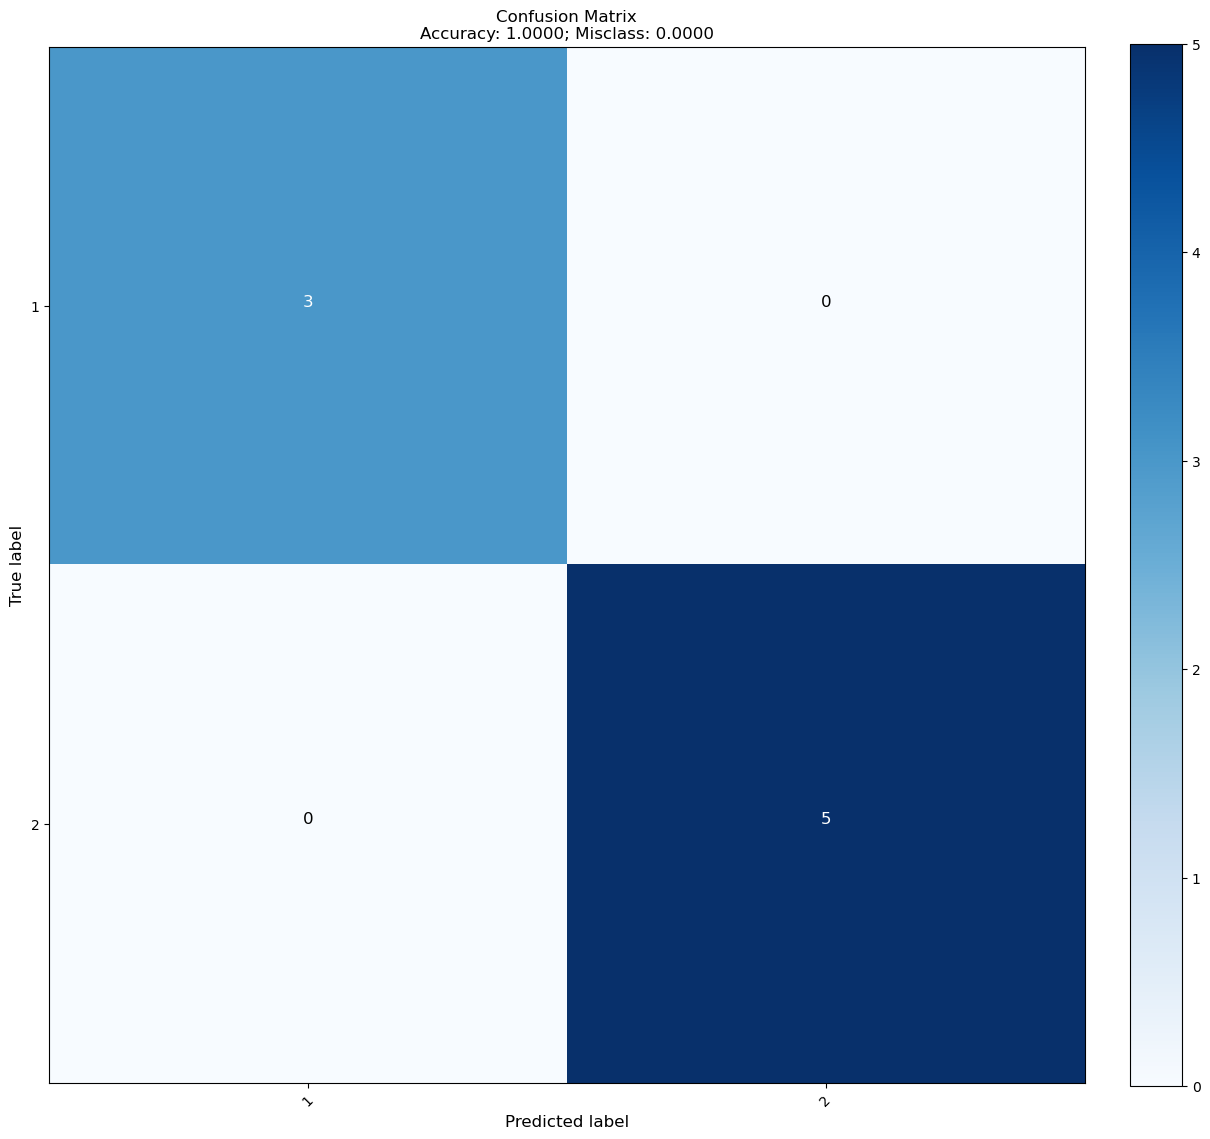

----Kernel: rbf, C: 10, gamma: 0.1 ----
Total number of matches: 8
Match rate: 1.00


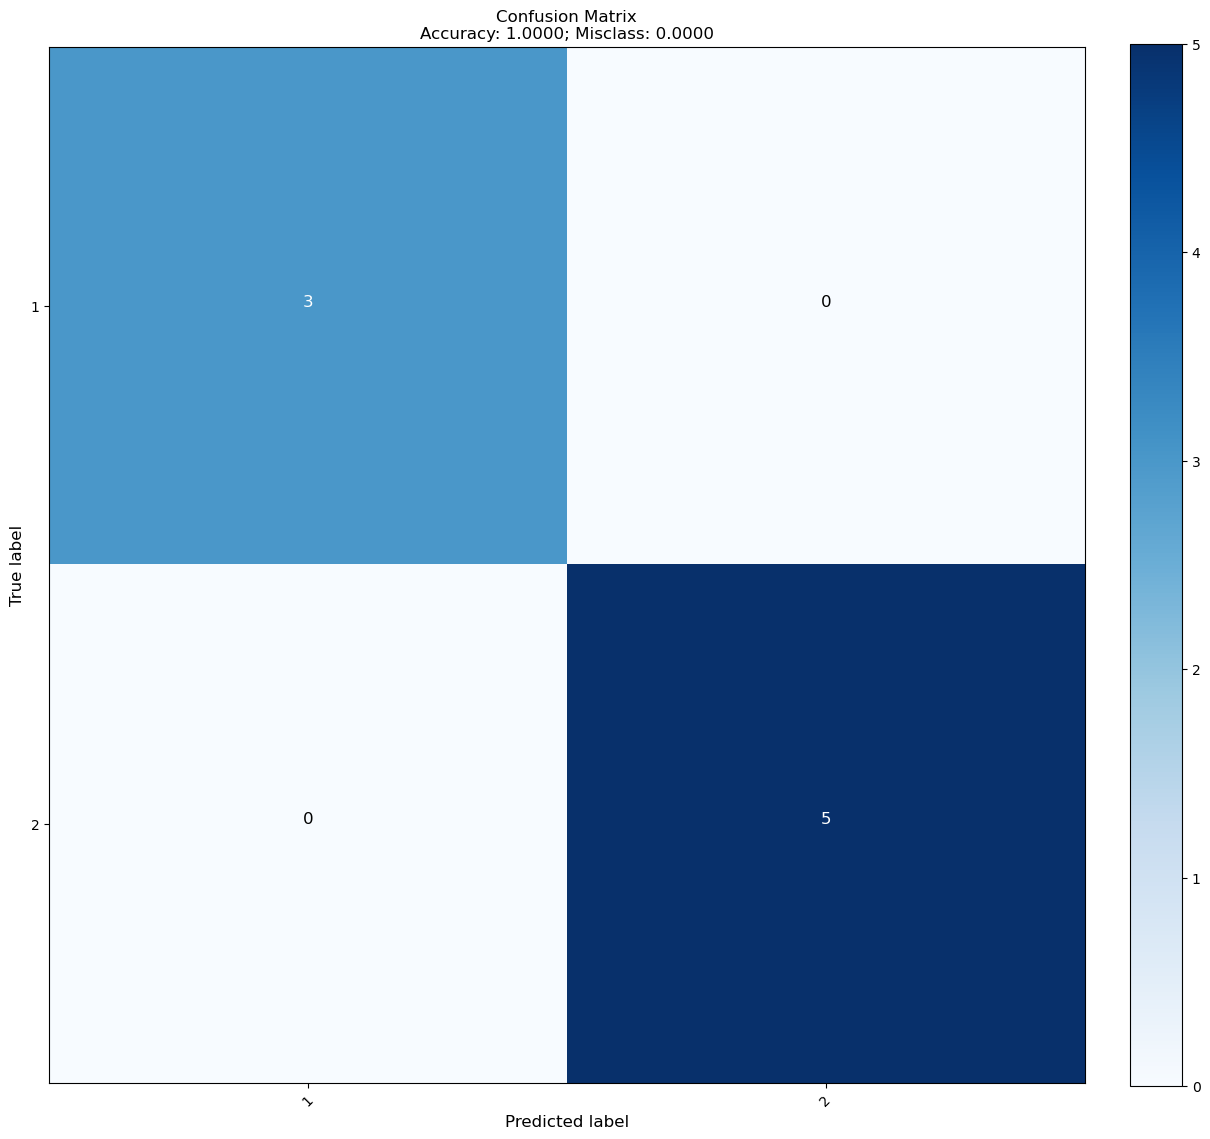

----Kernel: rbf, C: 10, gamma: 0.01 ----
Total number of matches: 8
Match rate: 1.00


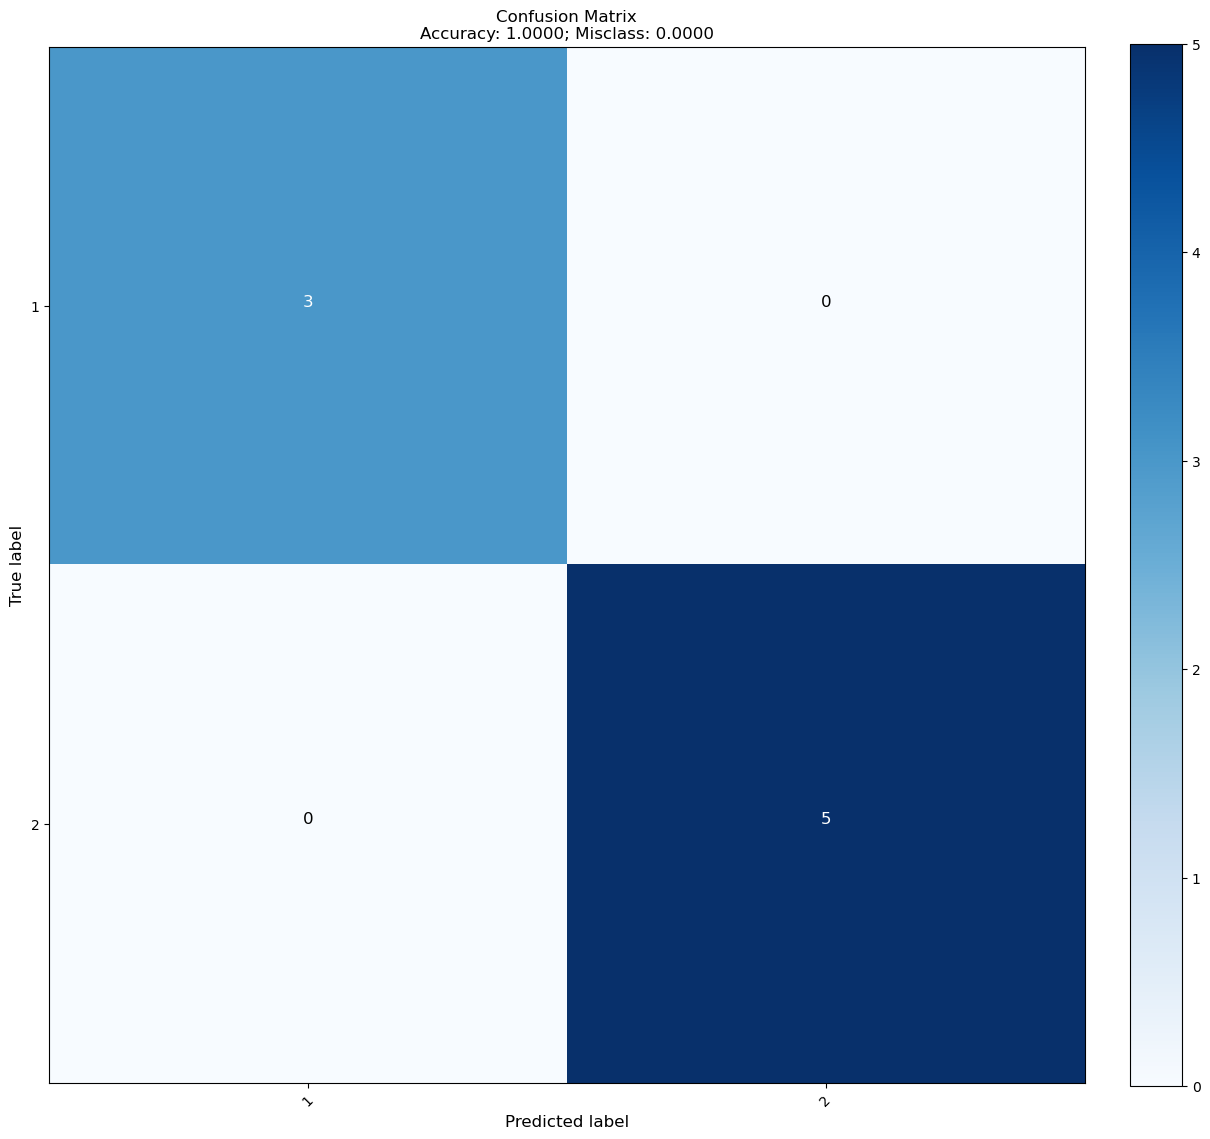

----Kernel: rbf, C: 10, gamma: 0.001 ----
Total number of matches: 8
Match rate: 1.00


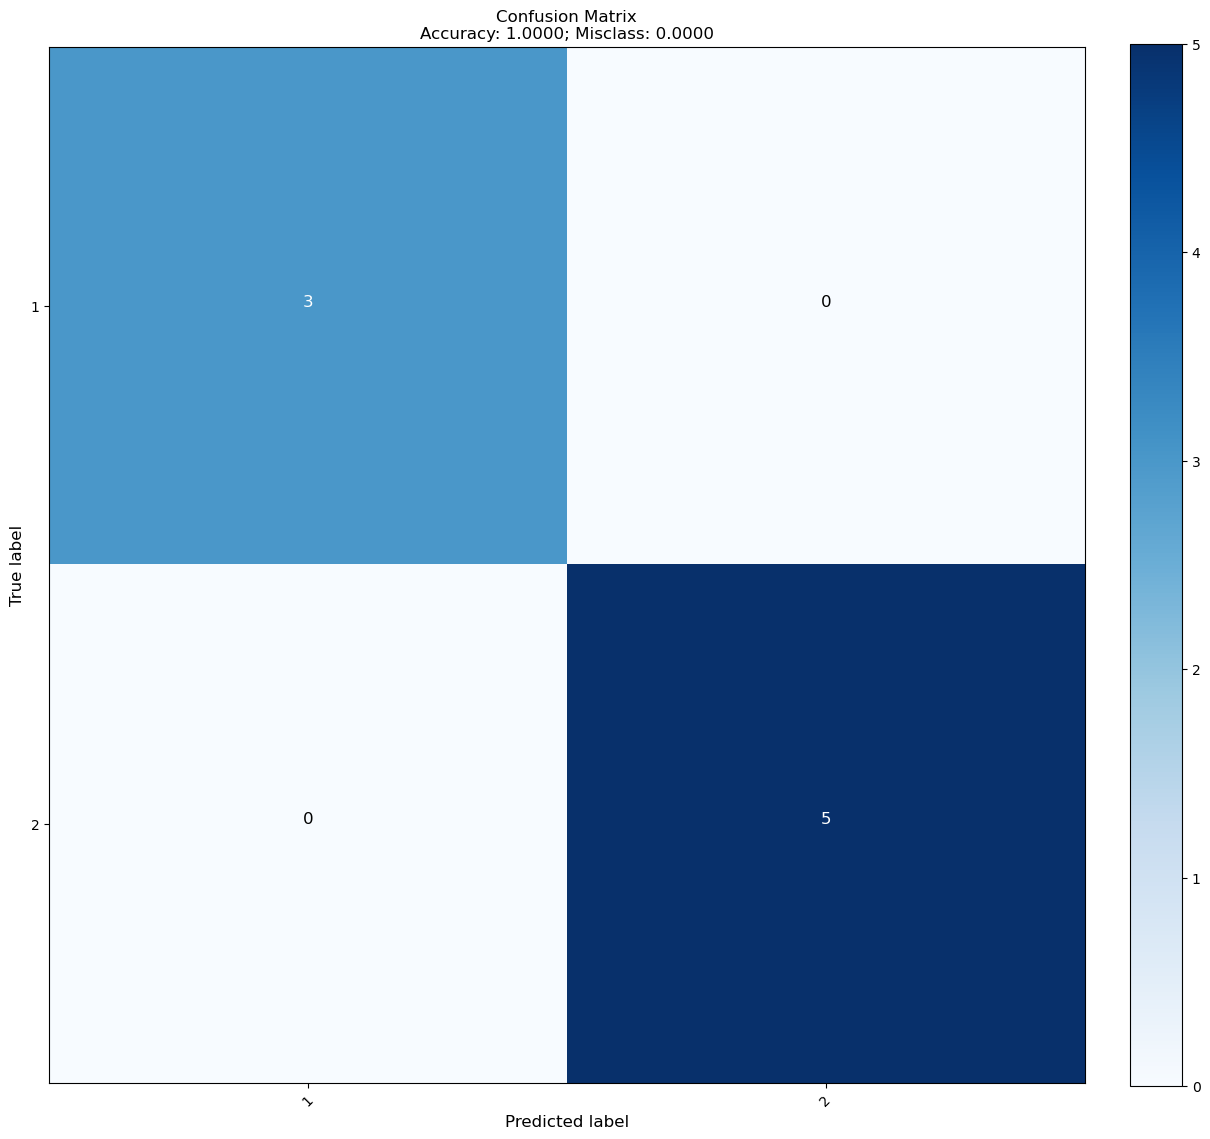

----Kernel: rbf, C: 100, gamma: 0.1 ----
Total number of matches: 8
Match rate: 1.00


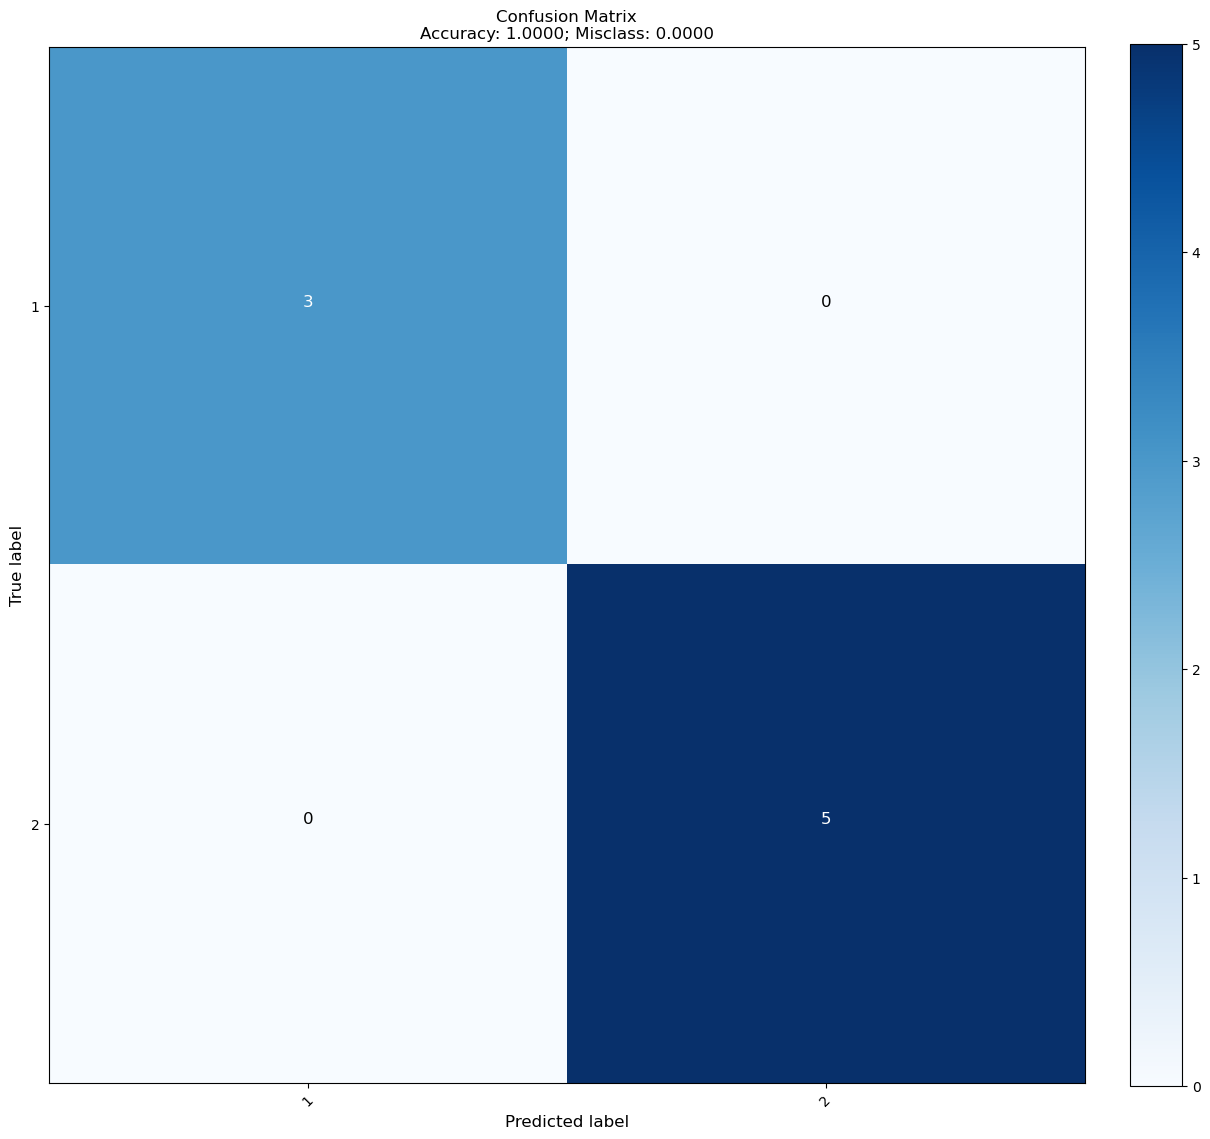

----Kernel: rbf, C: 100, gamma: 0.01 ----
Total number of matches: 8
Match rate: 1.00


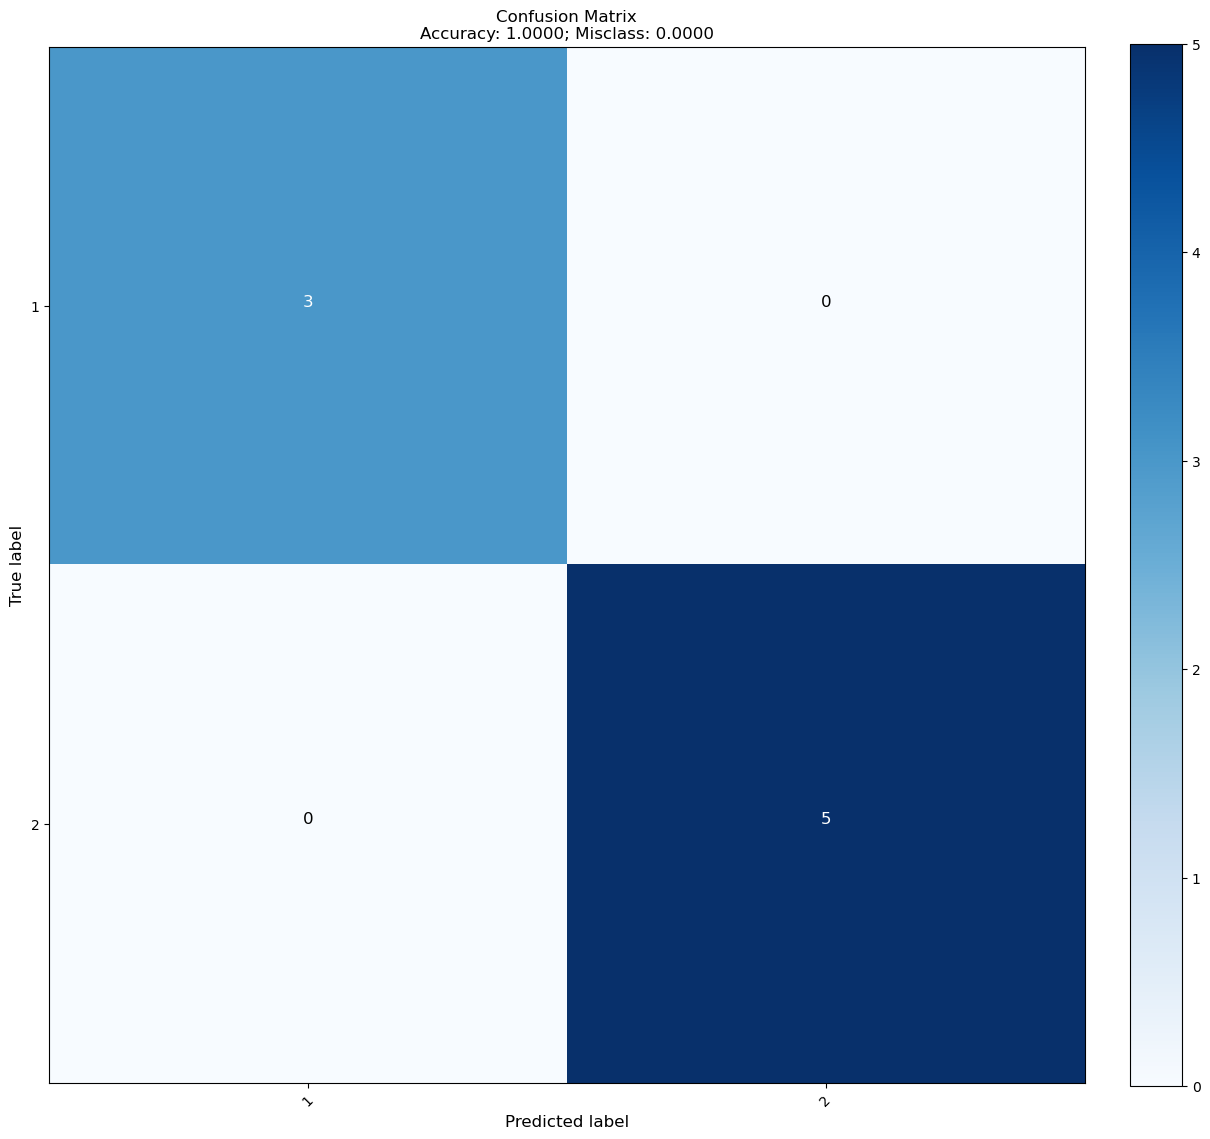

----Kernel: rbf, C: 100, gamma: 0.001 ----
Total number of matches: 8
Match rate: 1.00


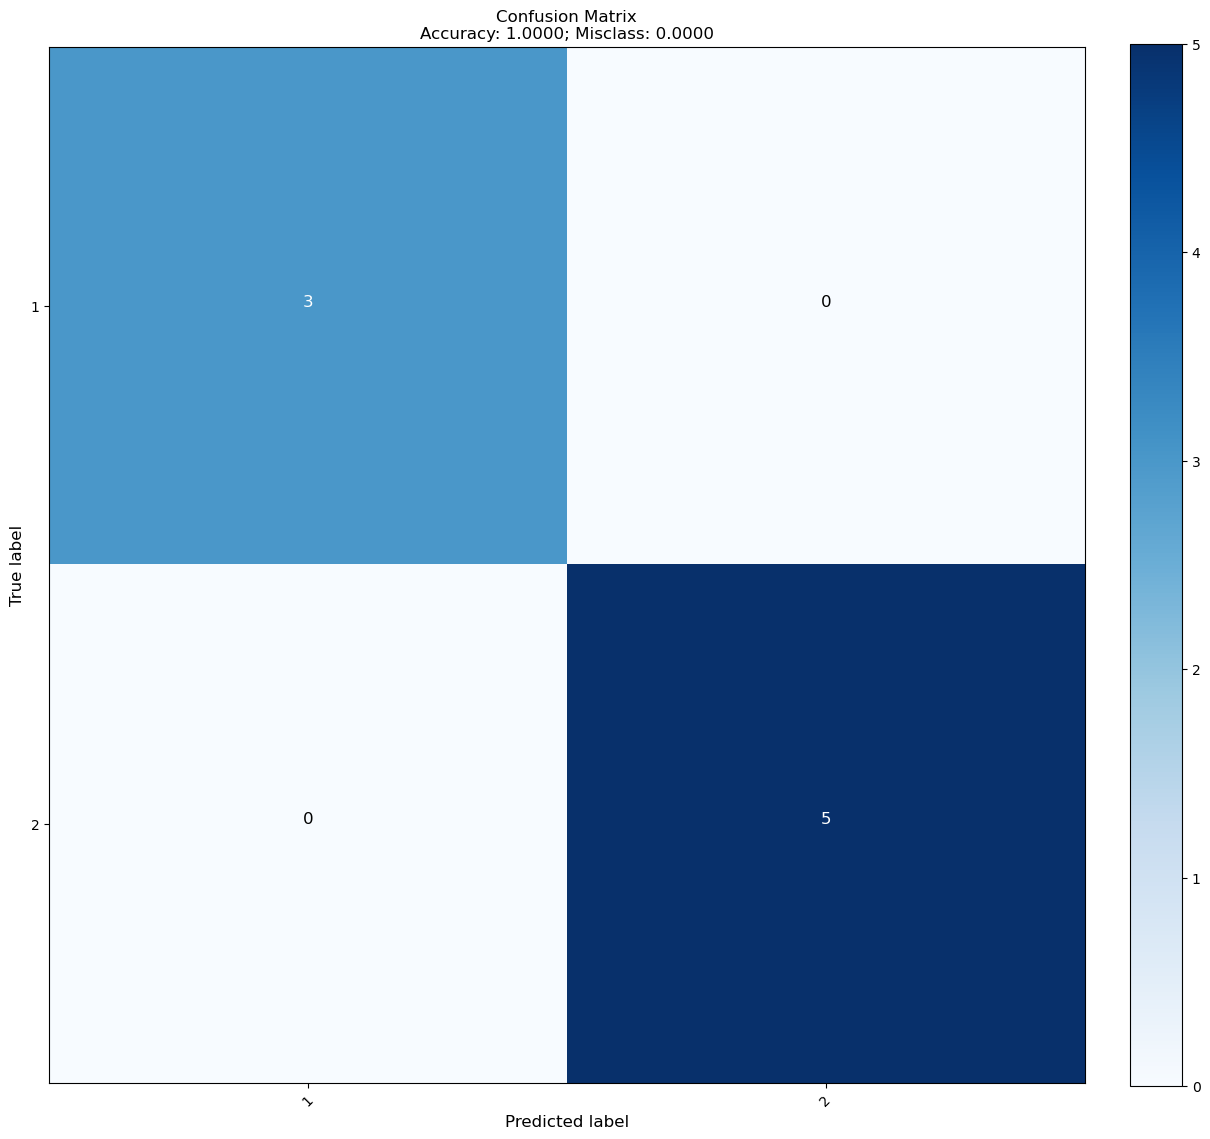

----Kernel: sigmoid, C: 1, gamma: 0.1 ----
Total number of matches: 7
Match rate: 0.88


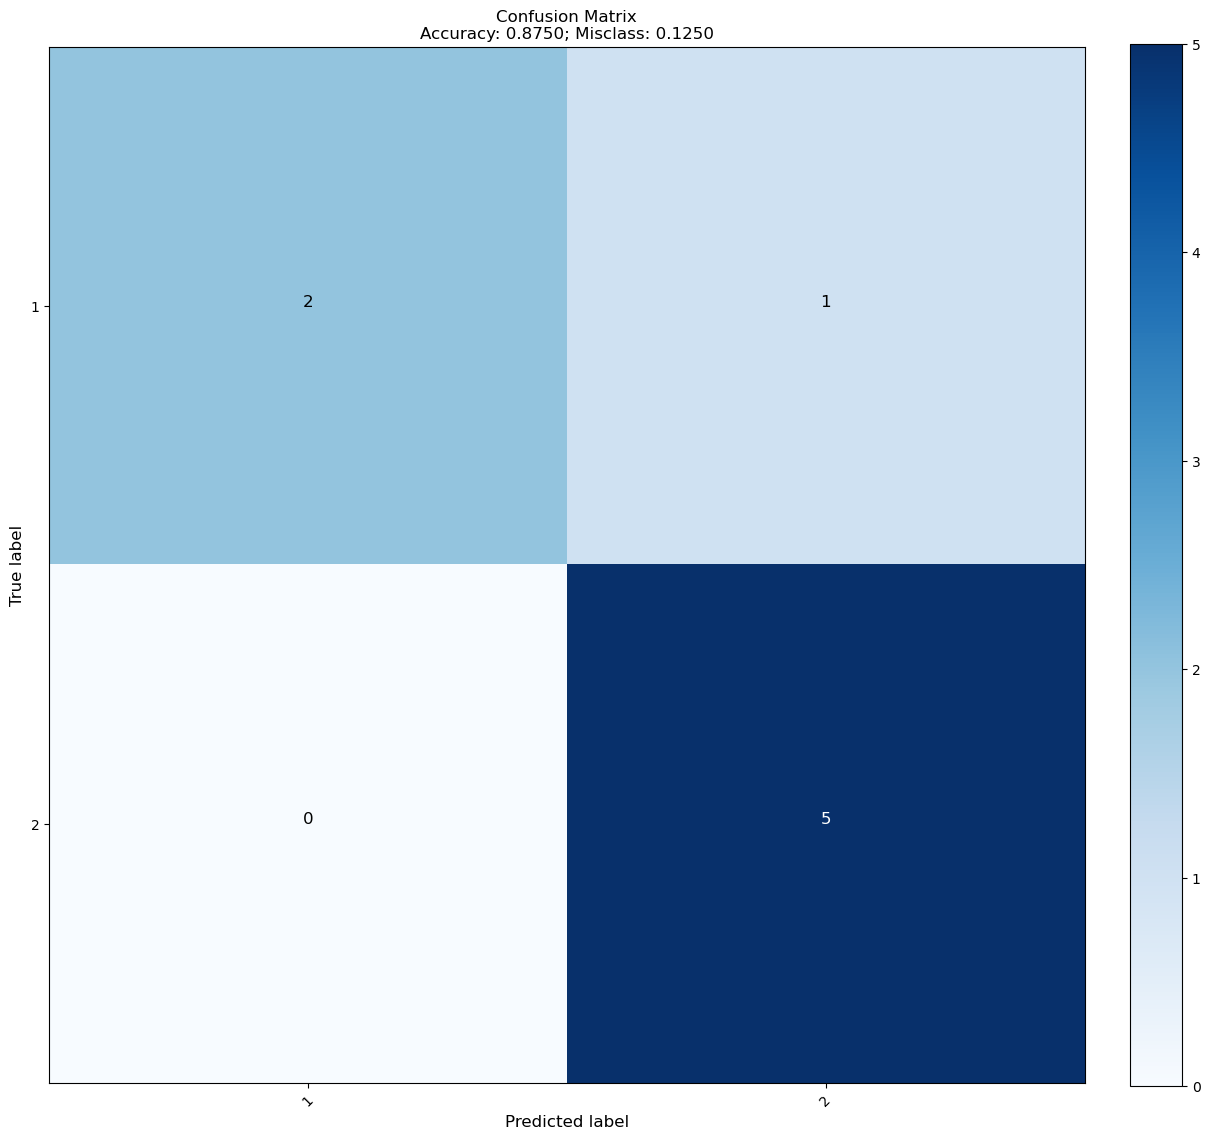

----Kernel: sigmoid, C: 1, gamma: 0.01 ----
Total number of matches: 7
Match rate: 0.88


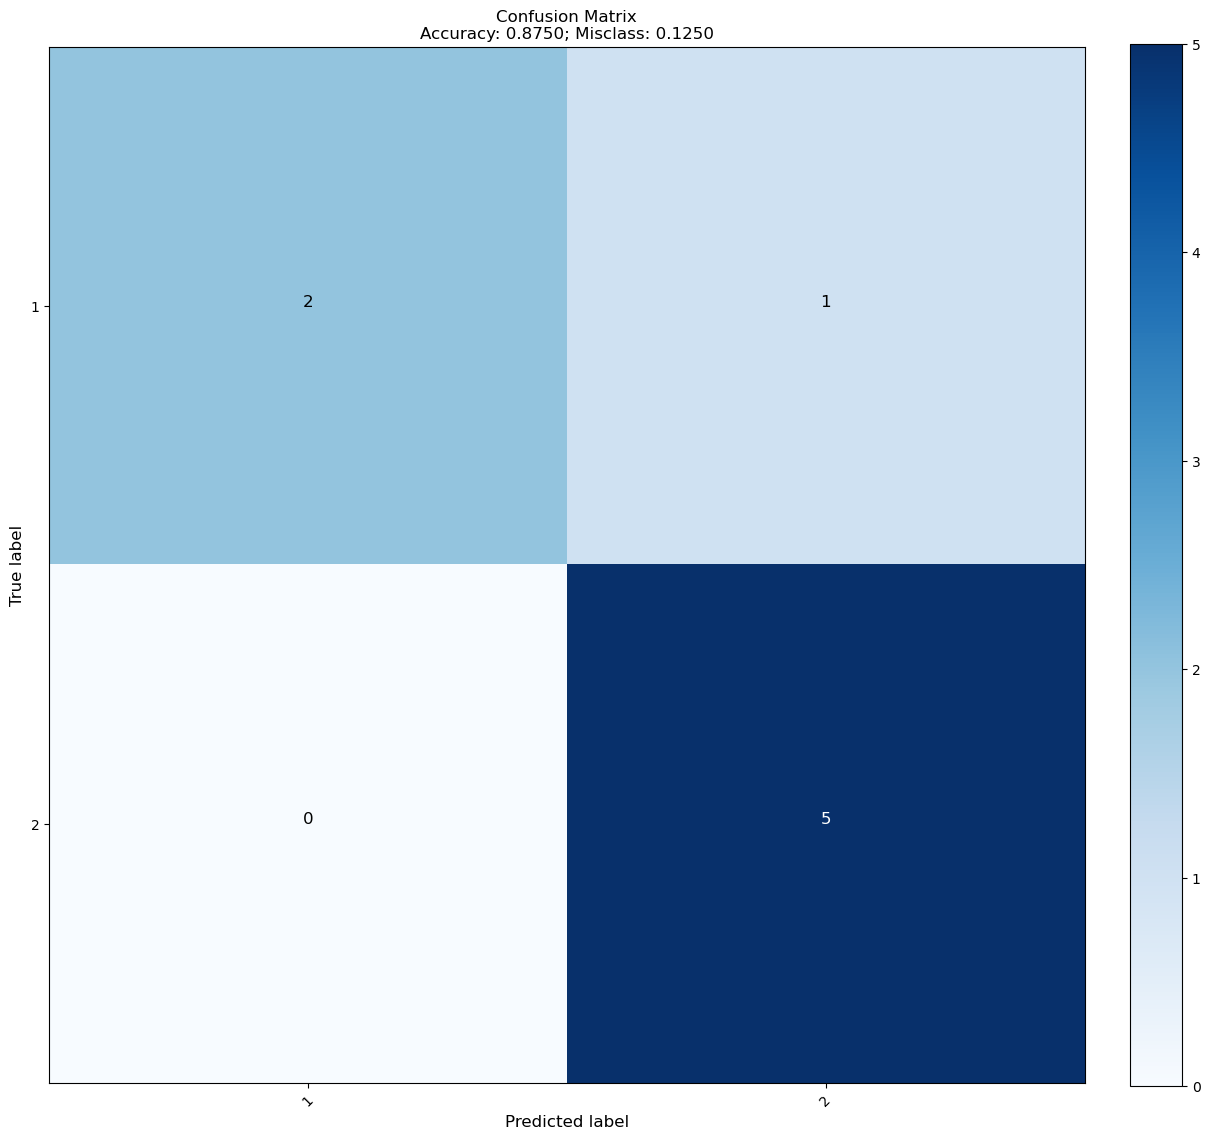

----Kernel: sigmoid, C: 1, gamma: 0.001 ----
Total number of matches: 7
Match rate: 0.88


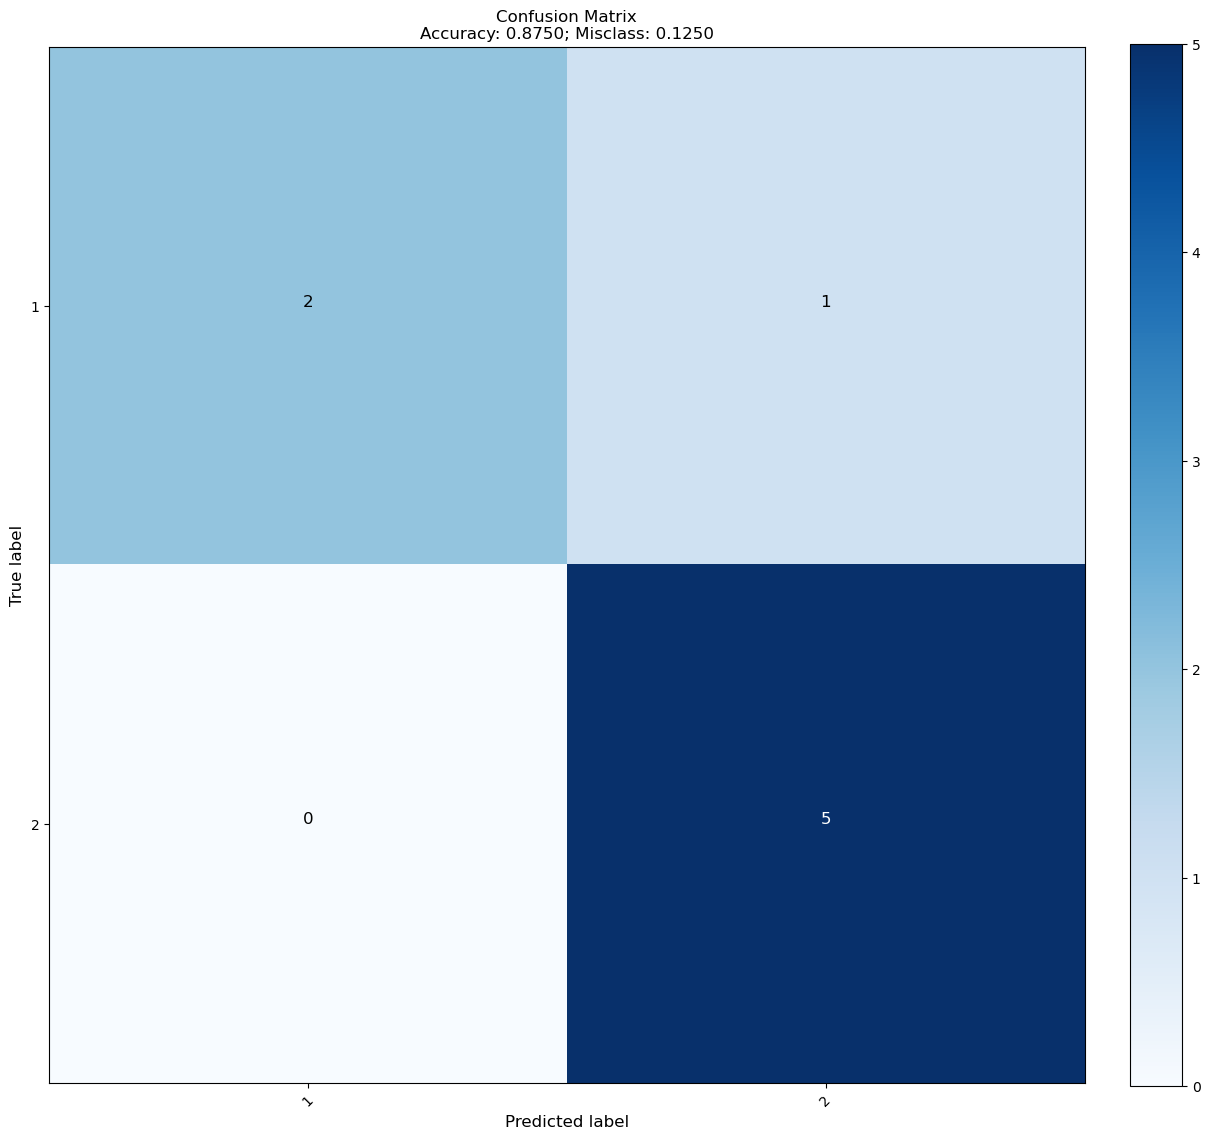

----Kernel: sigmoid, C: 10, gamma: 0.1 ----
Total number of matches: 7
Match rate: 0.88


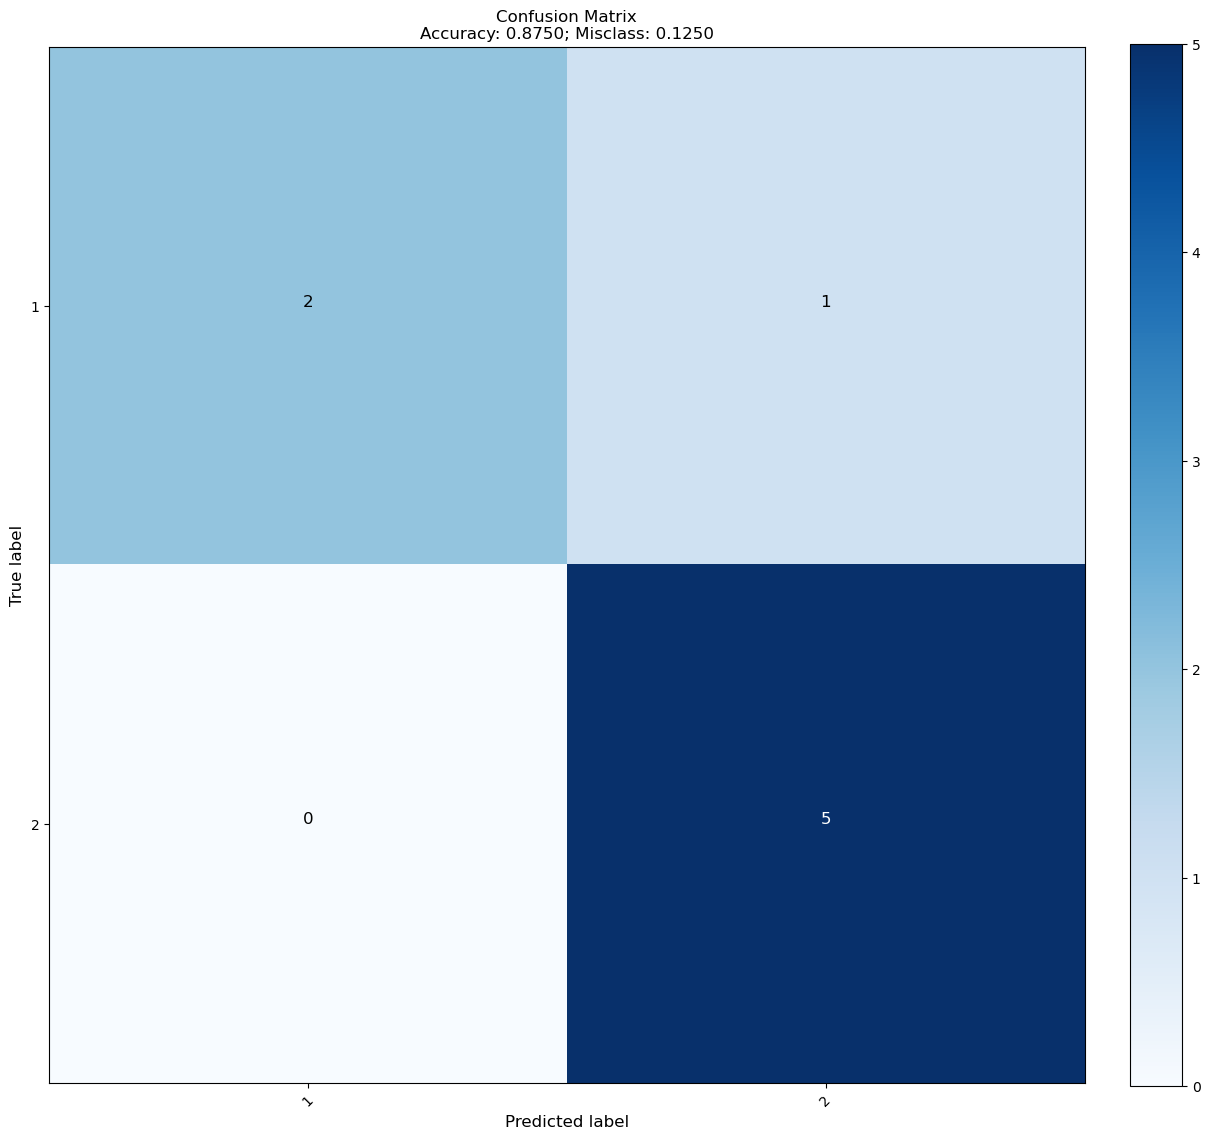

----Kernel: sigmoid, C: 10, gamma: 0.01 ----
Total number of matches: 7
Match rate: 0.88


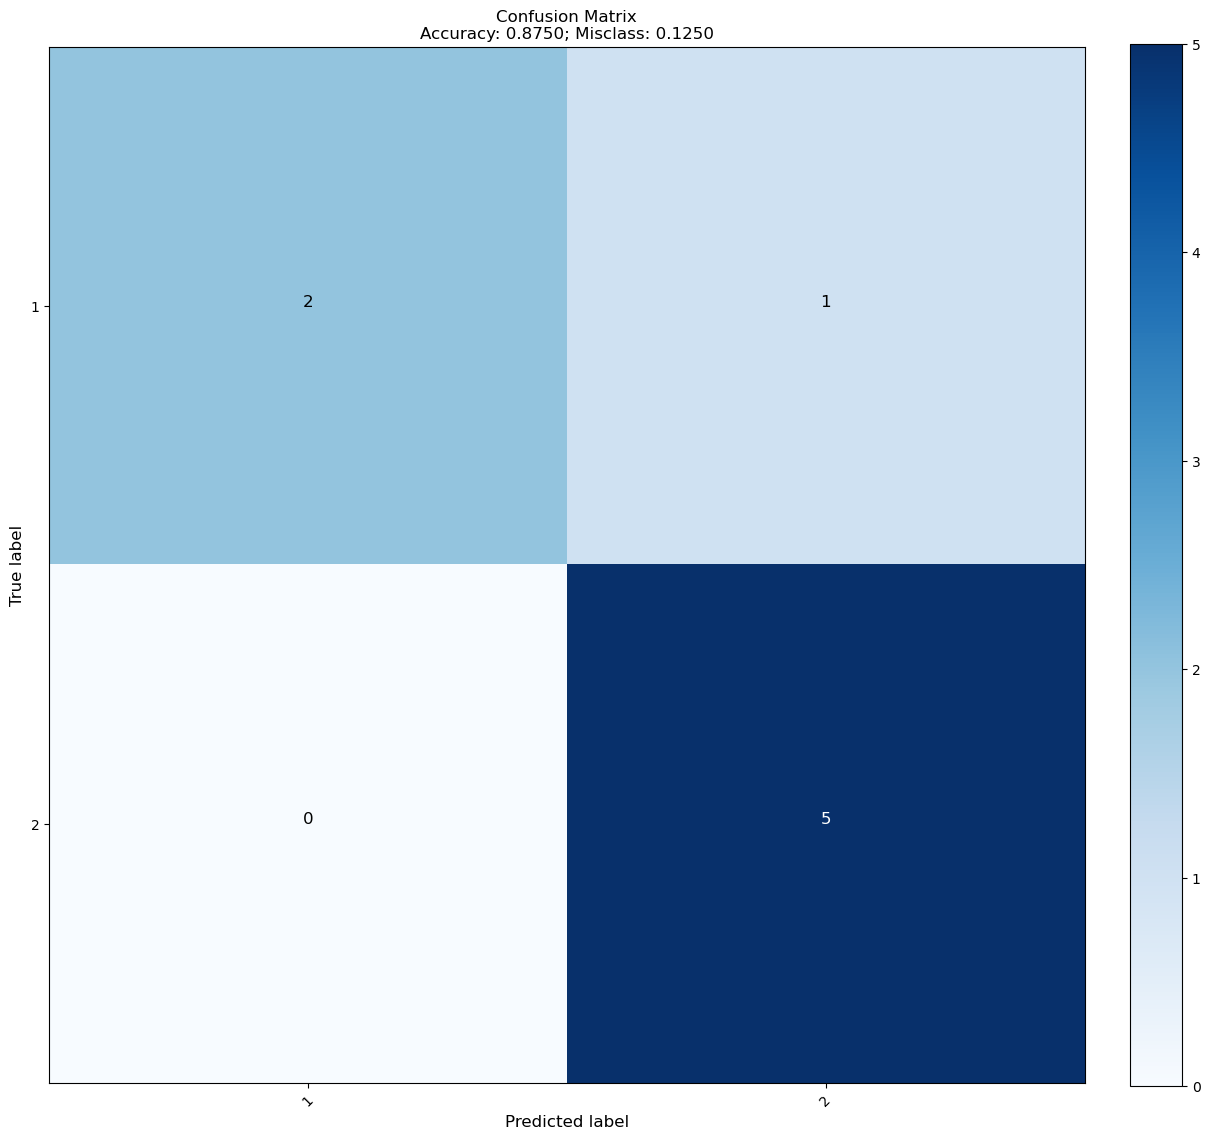

----Kernel: sigmoid, C: 10, gamma: 0.001 ----
Total number of matches: 7
Match rate: 0.88


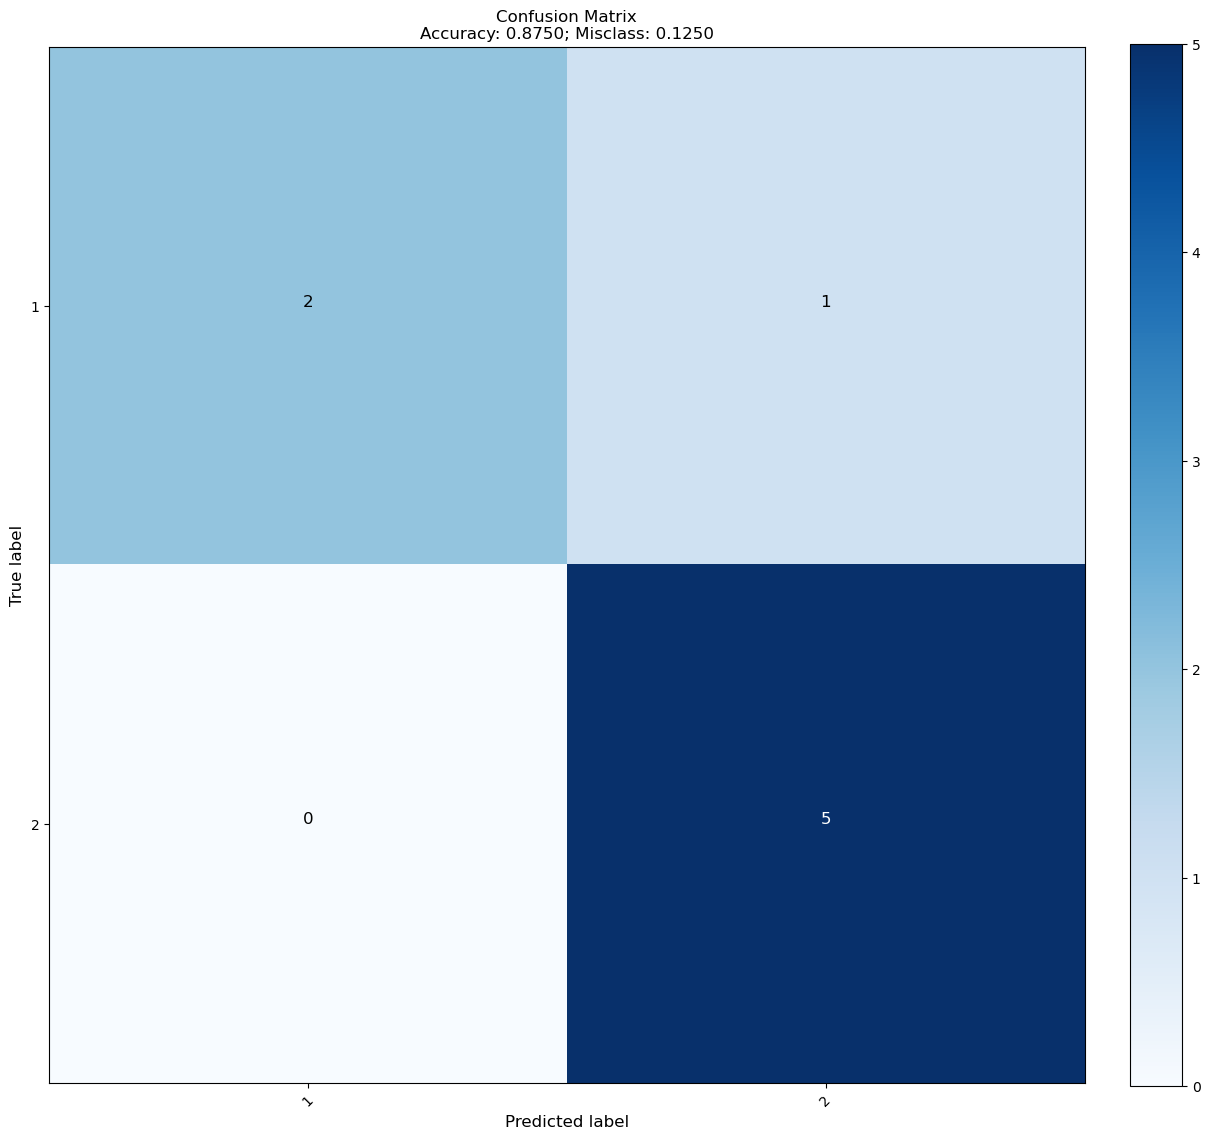

----Kernel: sigmoid, C: 100, gamma: 0.1 ----
Total number of matches: 7
Match rate: 0.88


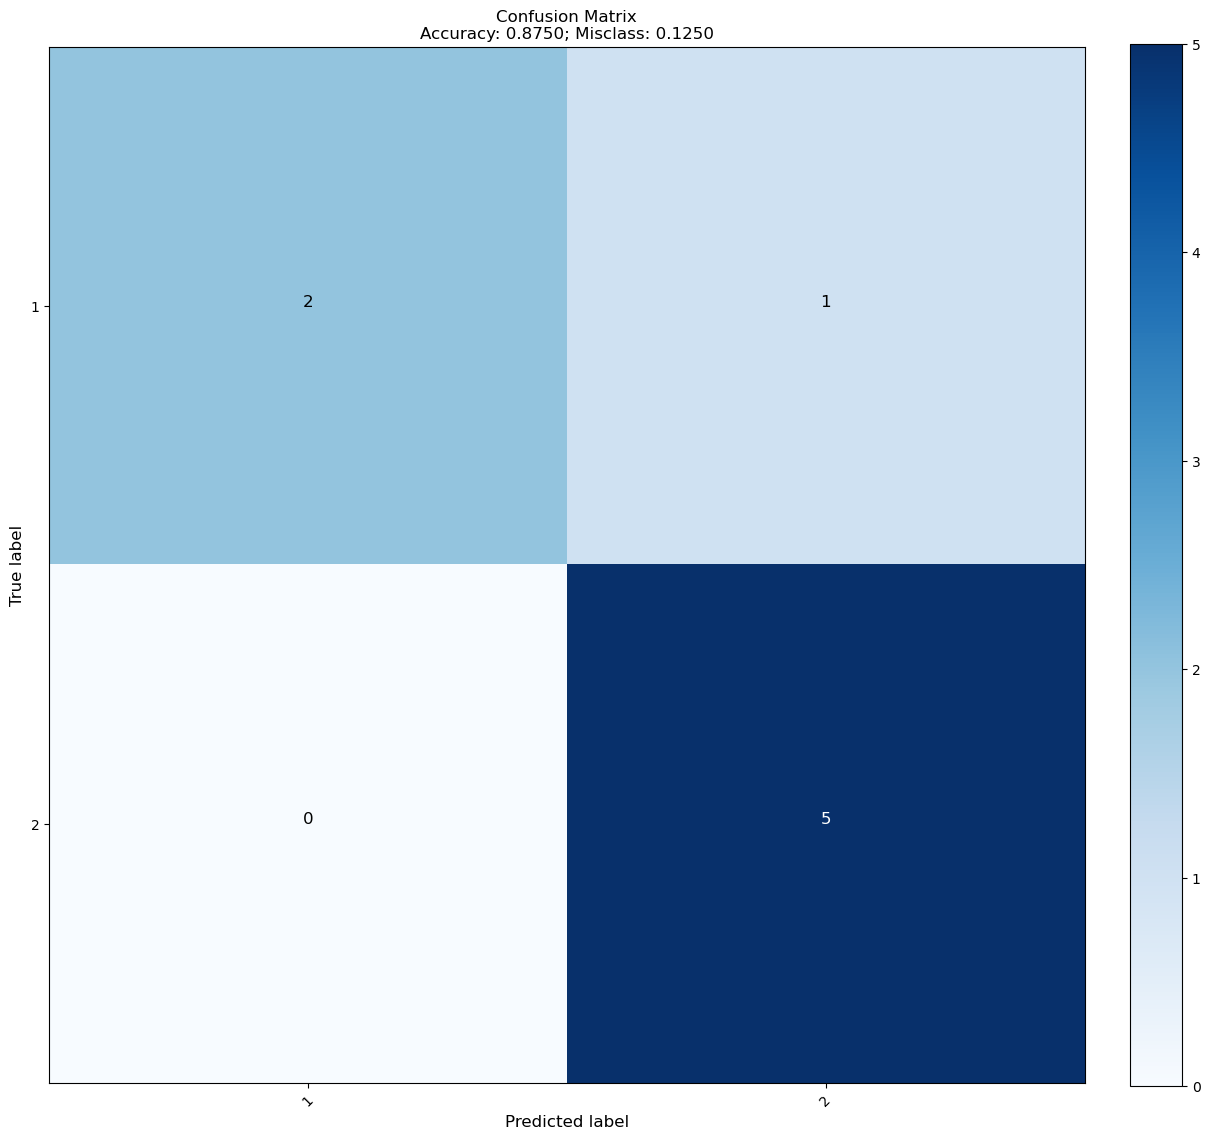

----Kernel: sigmoid, C: 100, gamma: 0.01 ----
Total number of matches: 7
Match rate: 0.88


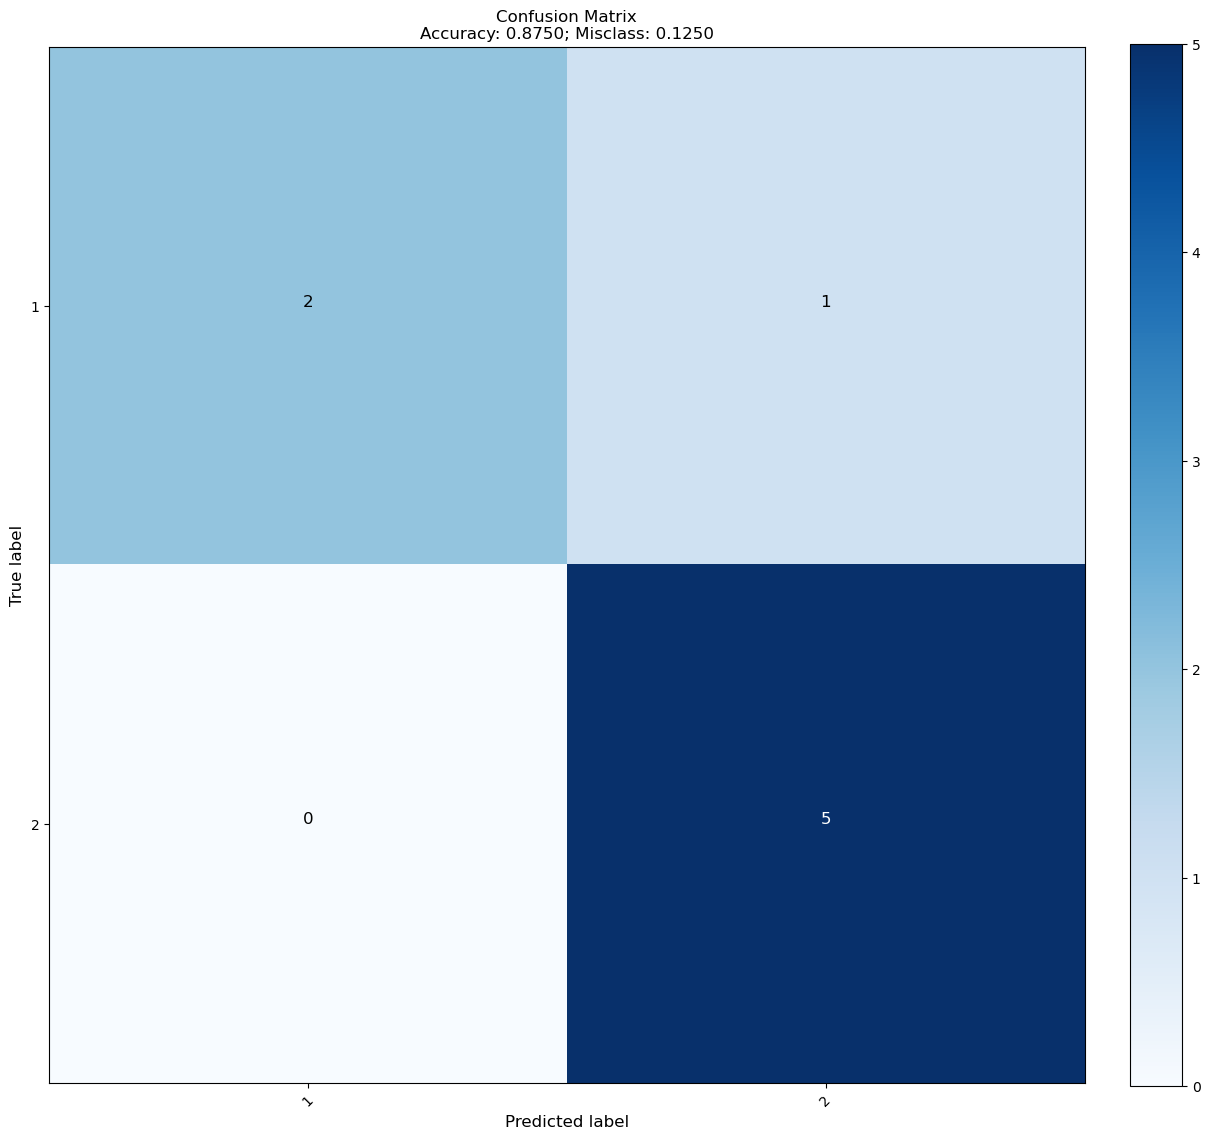

----Kernel: sigmoid, C: 100, gamma: 0.001 ----
Total number of matches: 7
Match rate: 0.88


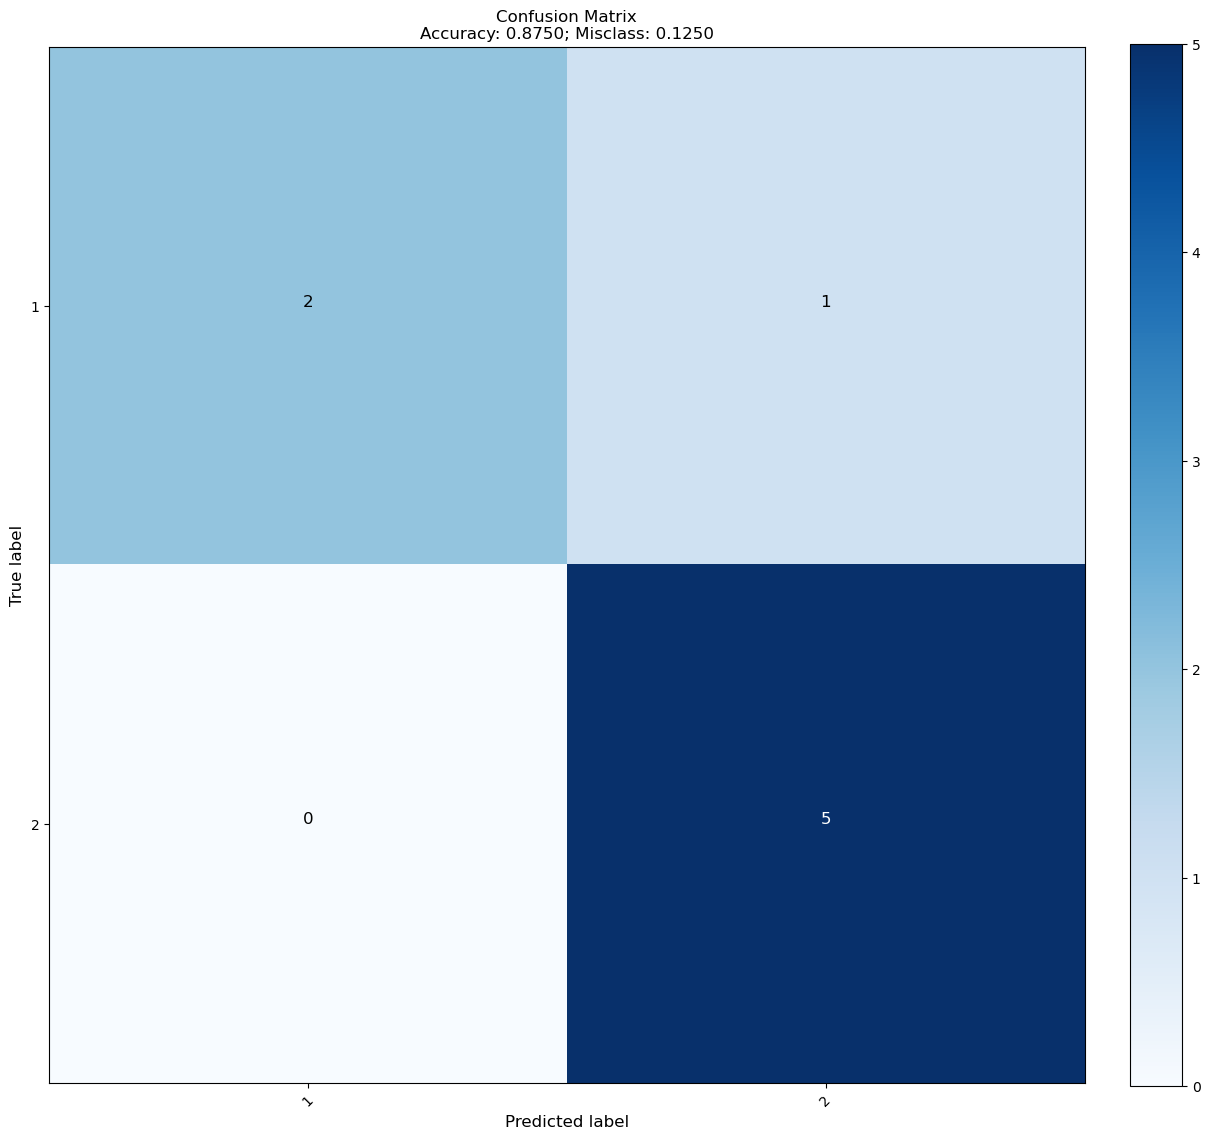

----Kernel: poly, C: 1, gamma: 0.1 ----
Total number of matches: 5
Match rate: 0.62


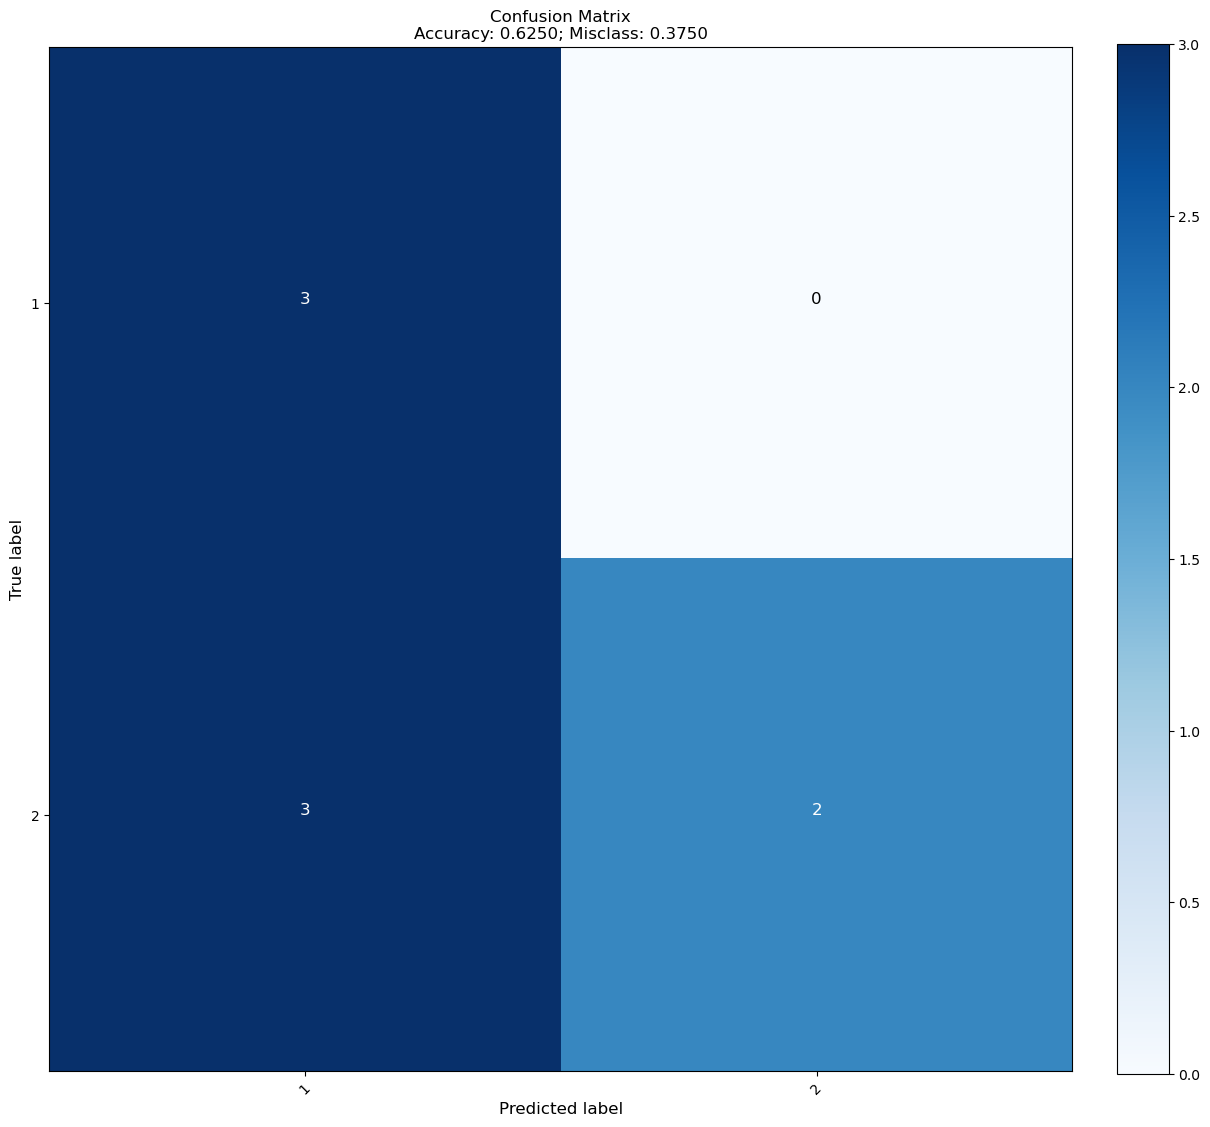

----Kernel: poly, C: 1, gamma: 0.01 ----
Total number of matches: 5
Match rate: 0.62


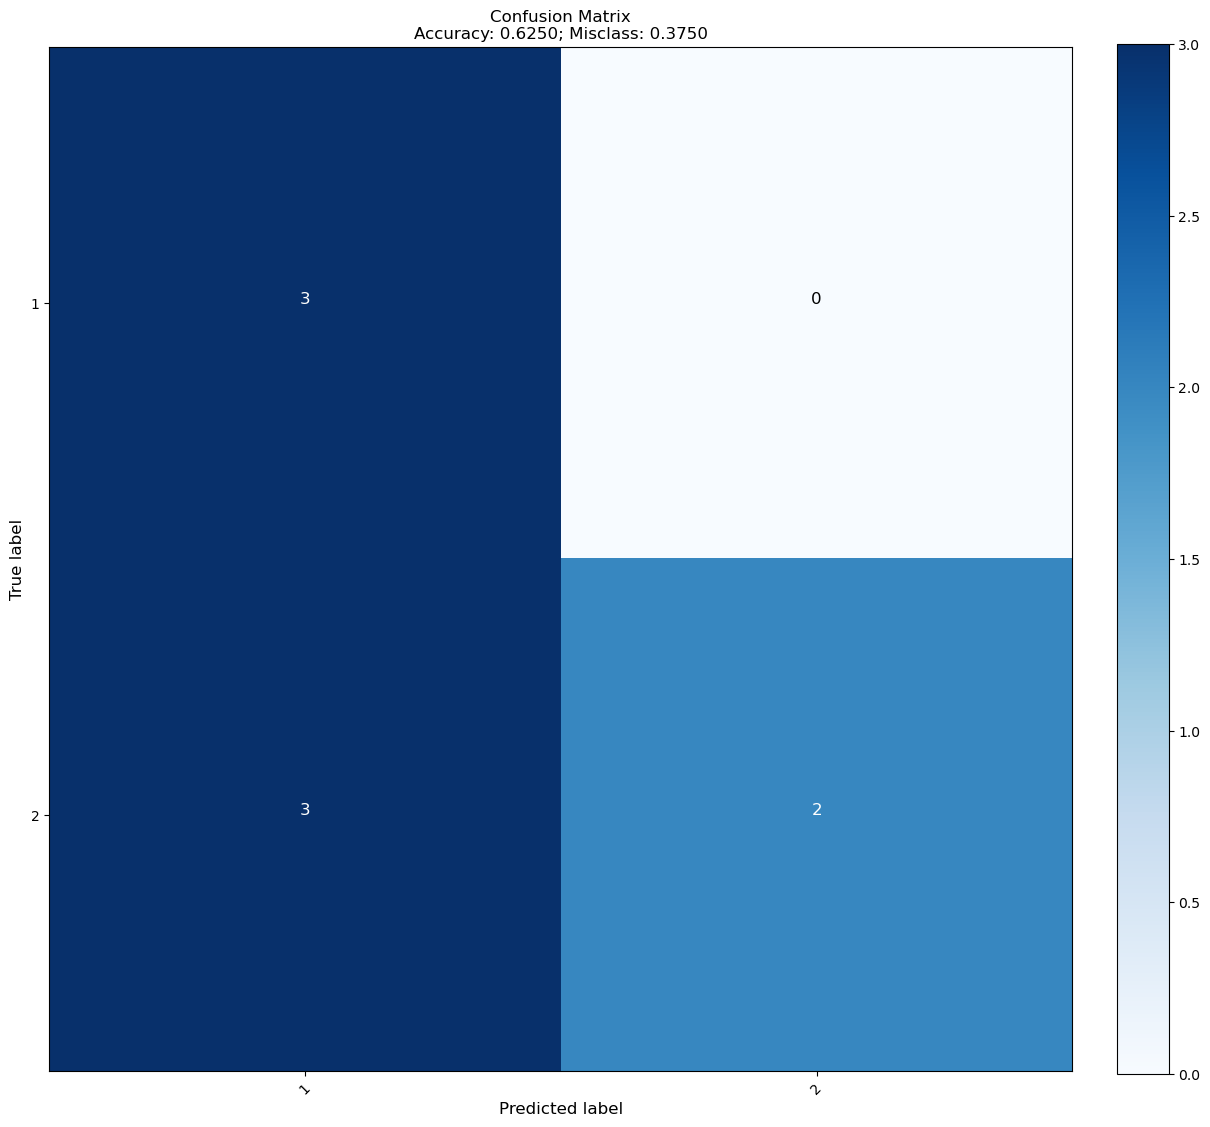

----Kernel: poly, C: 1, gamma: 0.001 ----
Total number of matches: 5
Match rate: 0.62


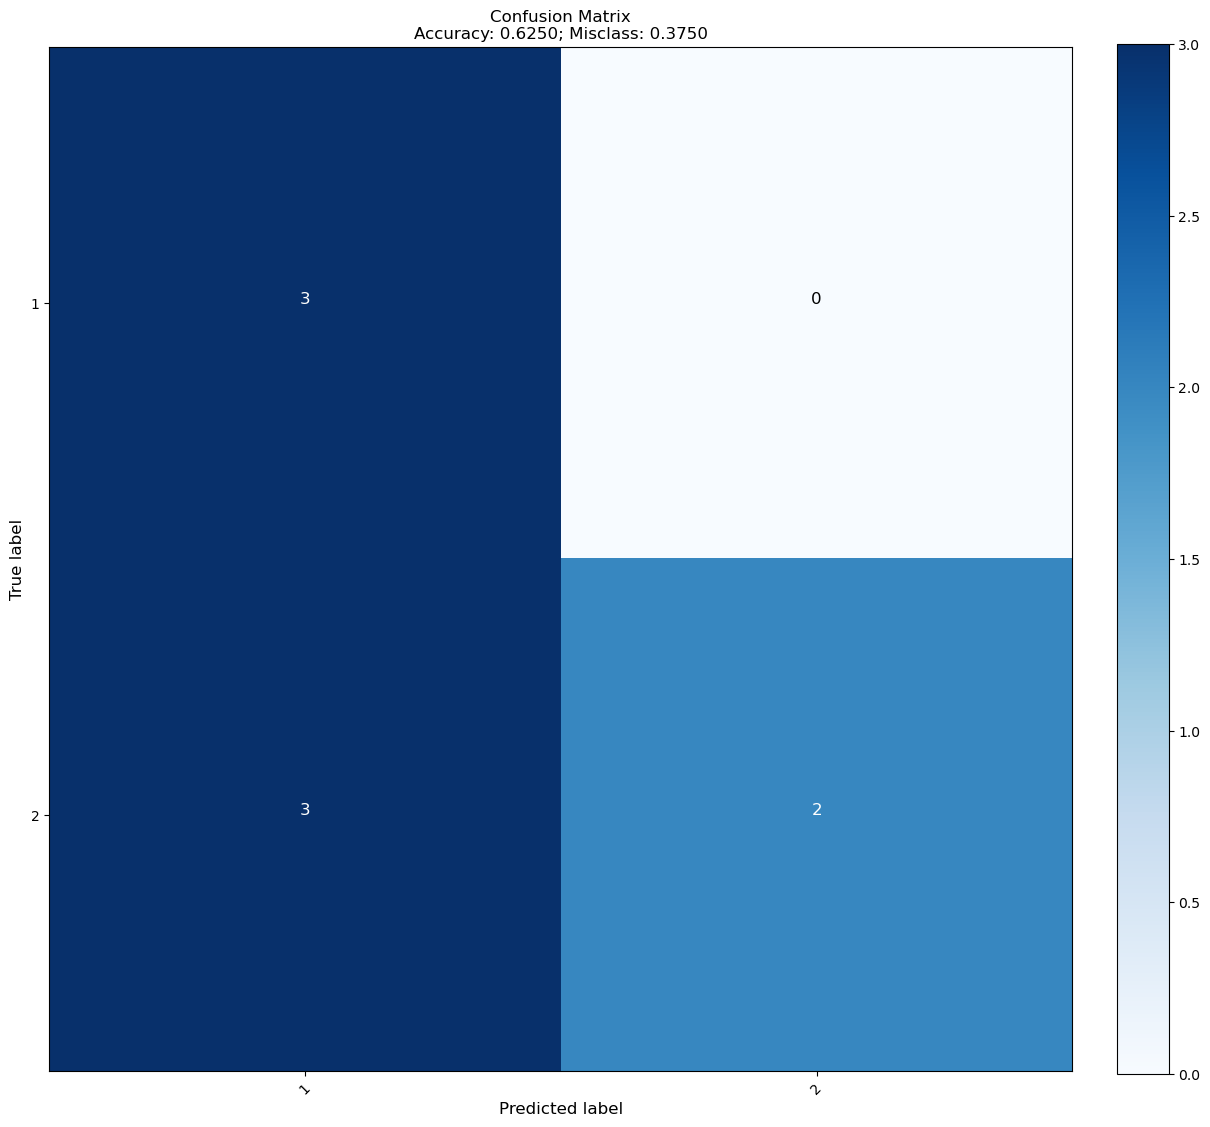

----Kernel: poly, C: 10, gamma: 0.1 ----
Total number of matches: 5
Match rate: 0.62


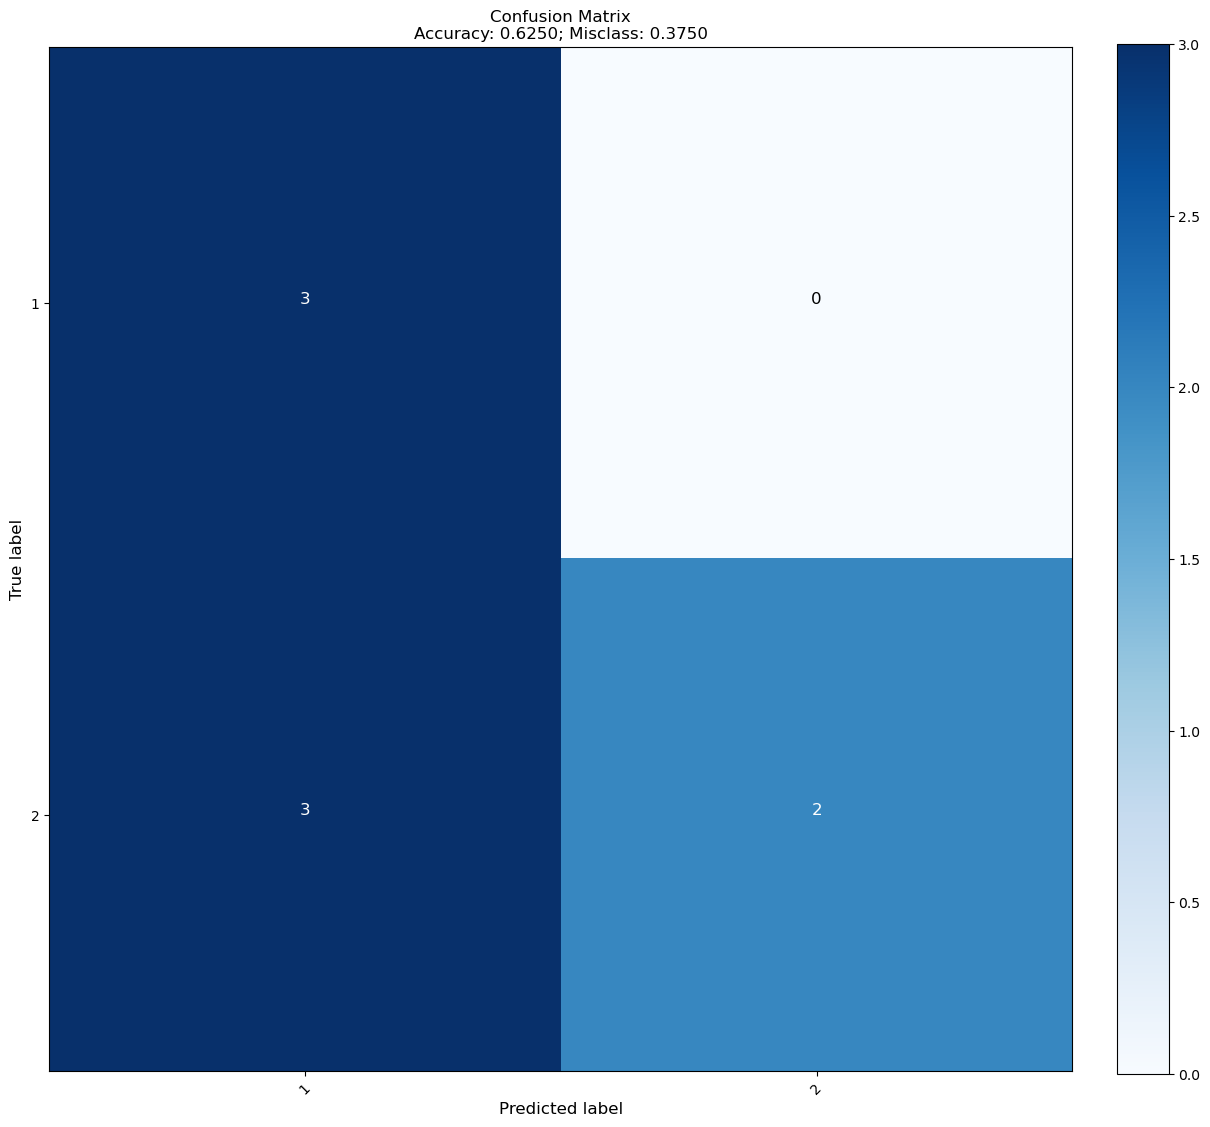

----Kernel: poly, C: 10, gamma: 0.01 ----
Total number of matches: 5
Match rate: 0.62


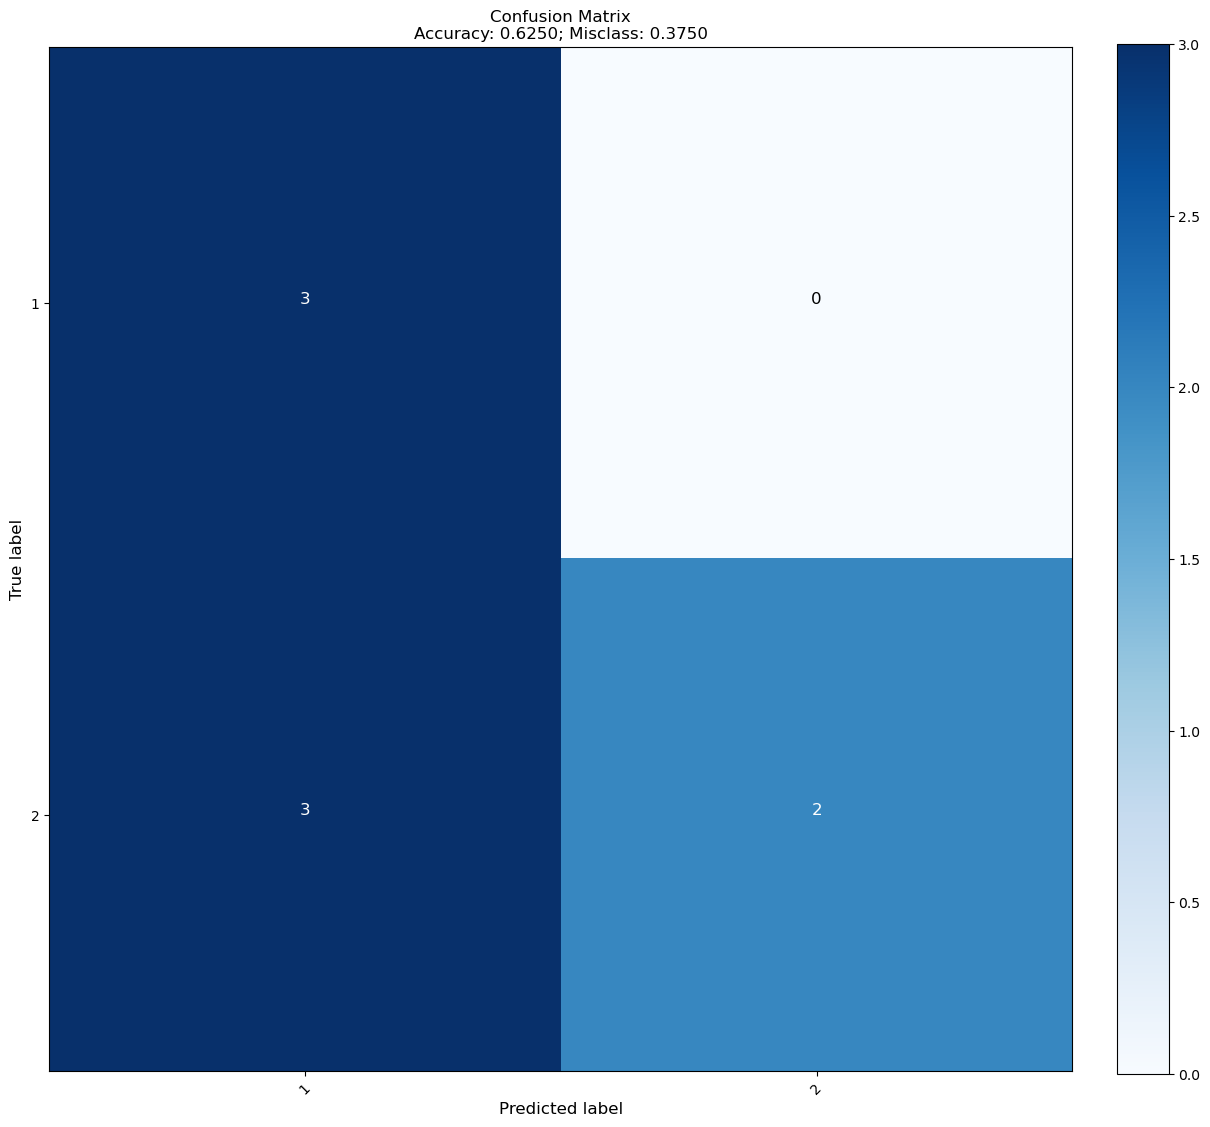

----Kernel: poly, C: 10, gamma: 0.001 ----
Total number of matches: 5
Match rate: 0.62


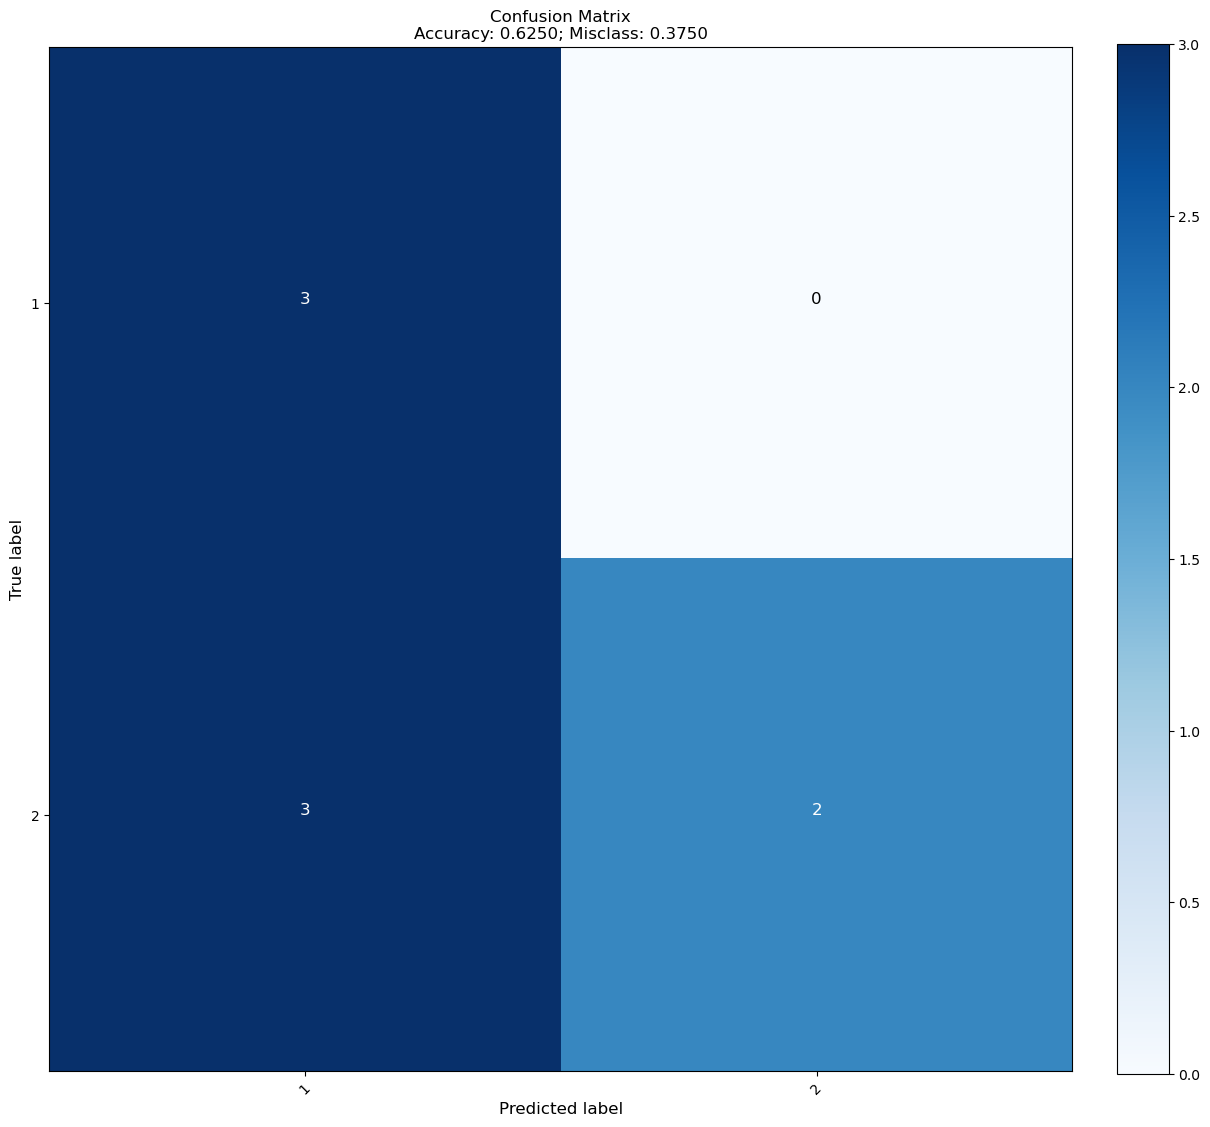

----Kernel: poly, C: 100, gamma: 0.1 ----
Total number of matches: 5
Match rate: 0.62


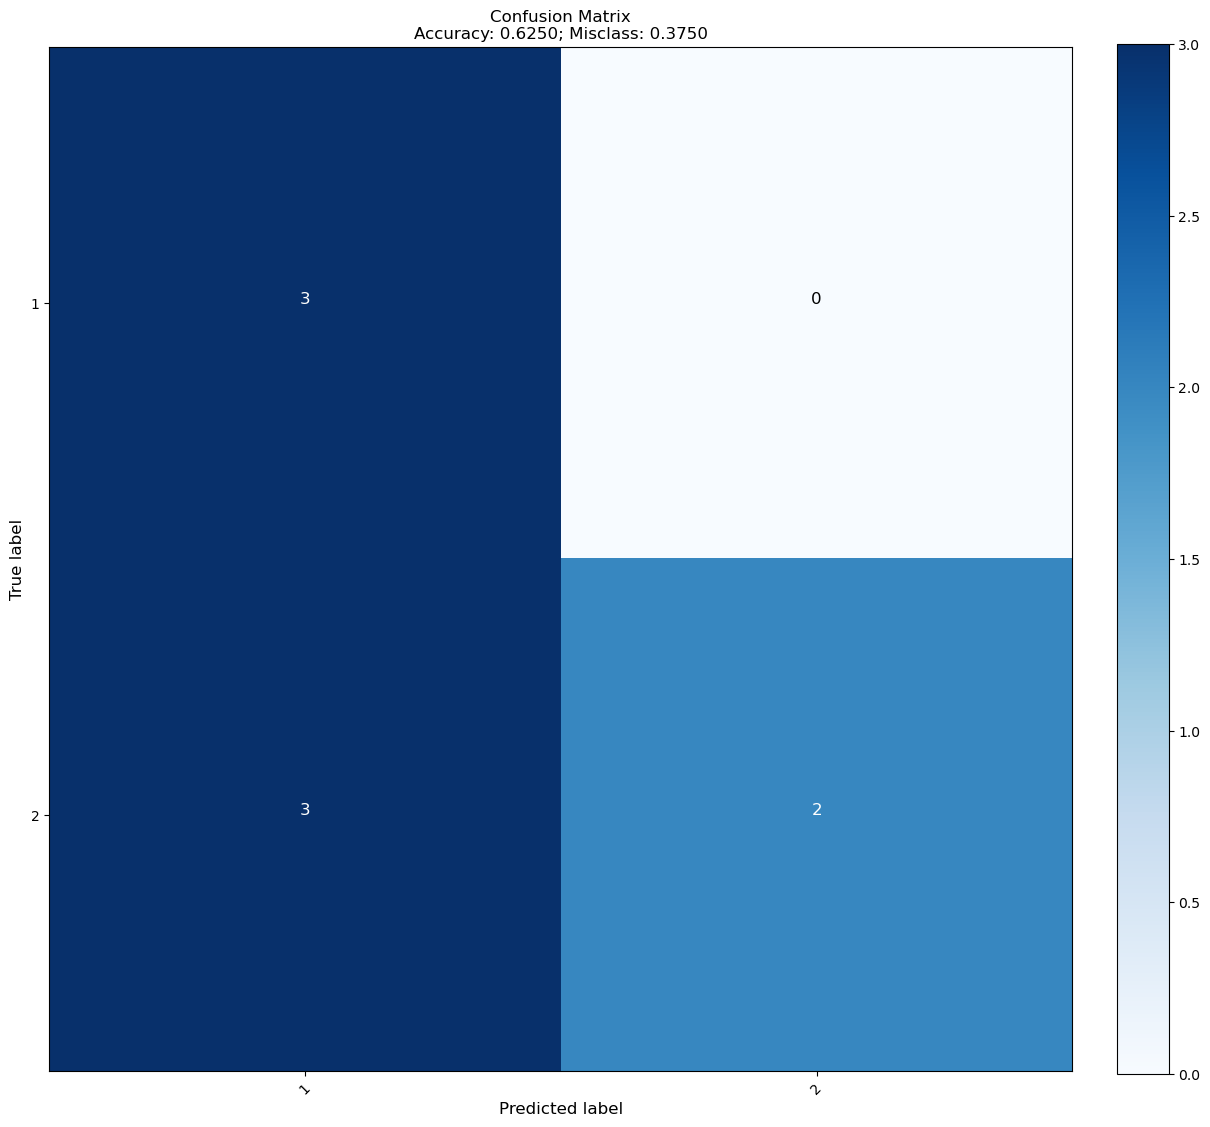

----Kernel: poly, C: 100, gamma: 0.01 ----
Total number of matches: 5
Match rate: 0.62


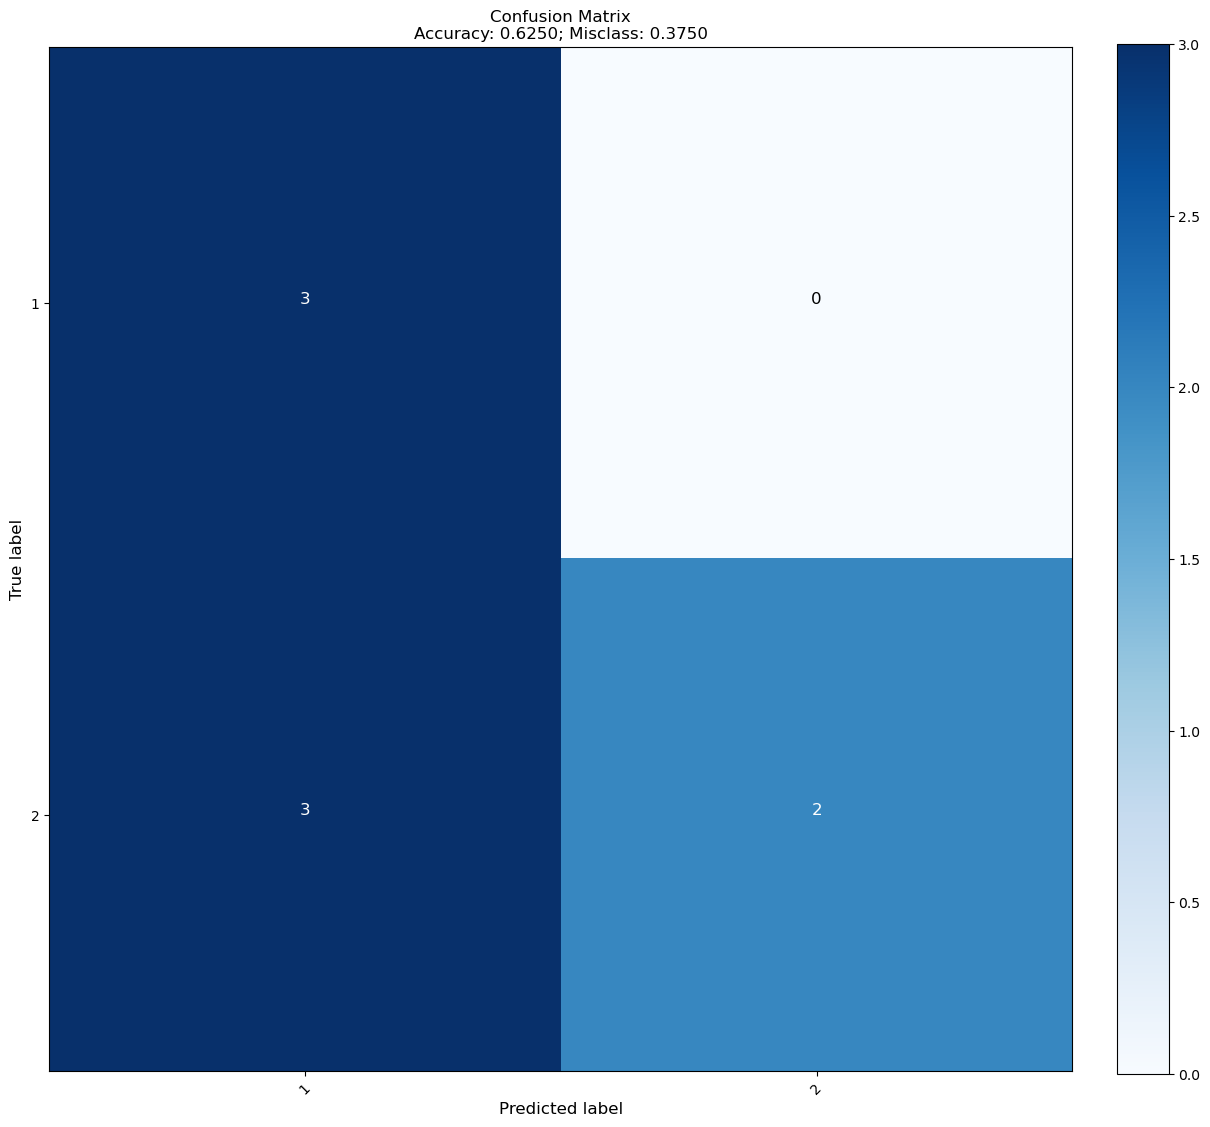

----Kernel: poly, C: 100, gamma: 0.001 ----
Total number of matches: 5
Match rate: 0.62


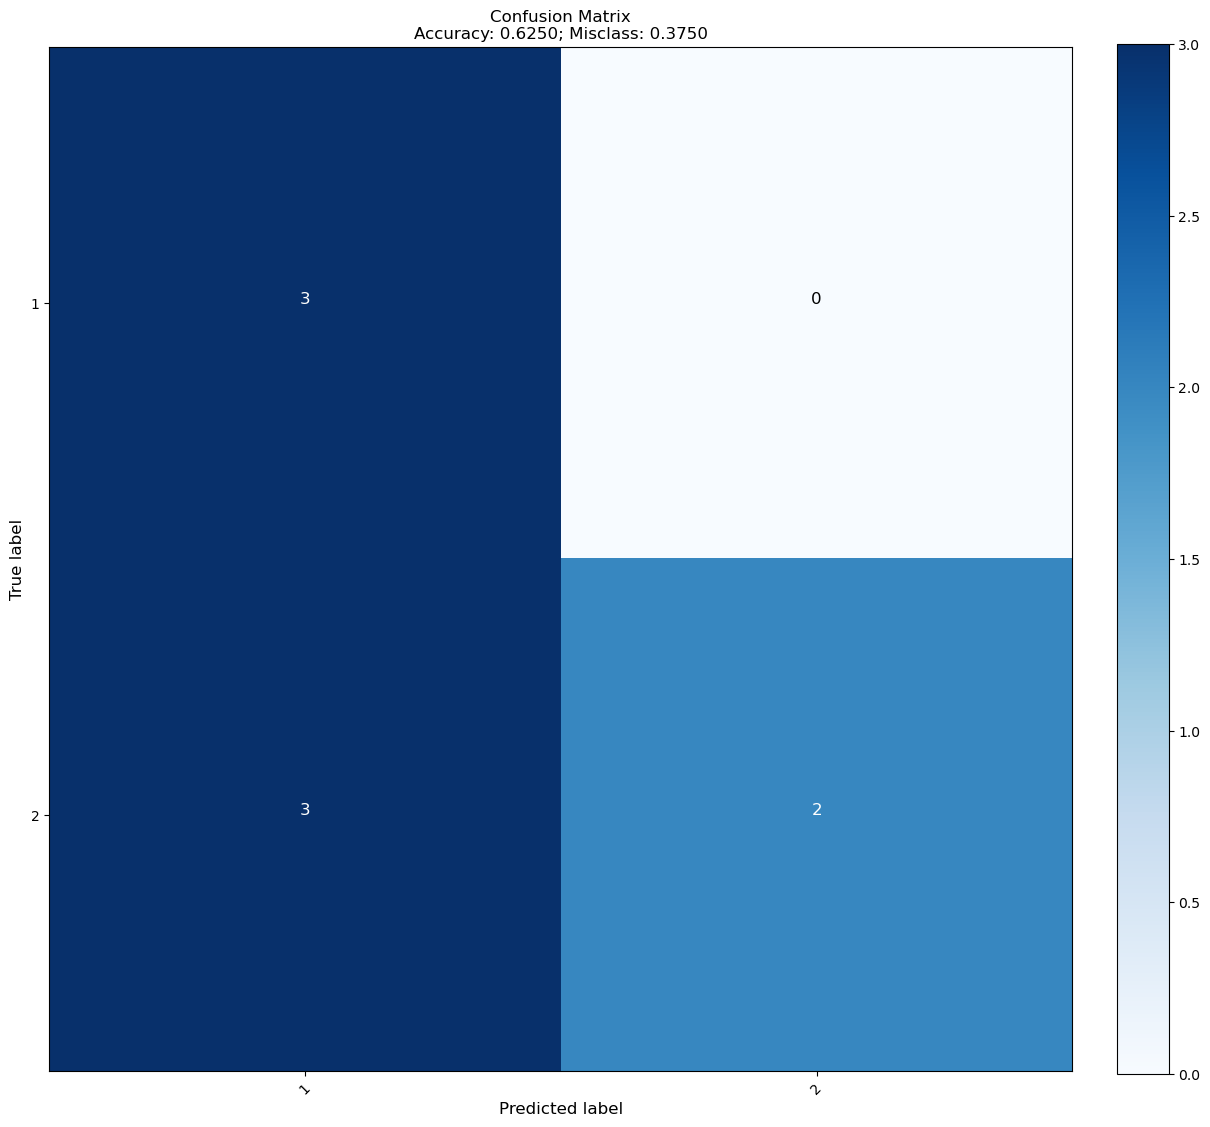

In [12]:
svc_types = ['linear', 'rbf', 'sigmoid', 'poly']
C_list = [1,10,100]
gamma_list = [0.1, 0.01, 0.001]
n_subjects = 2
for kernel in svc_types:
    for C in C_list:
        for gamma in gamma_list:
            print(f"----Kernel: {kernel}, C: {C}, gamma: {gamma} ----")
            clf = SVC(kernel=kernel)
            clf.fit(d2_train_dataset, y_train)
            y_pred = clf.predict(d2_test_dataset)
            matches = (y_pred == y_test)
            print('Total number of matches: %d' % (matches.sum()))

            match_rate = matches.sum() / float(len(matches))
            print('Match rate: %.2f' % (match_rate))
            # Generate the confusion matrix
            confusionMatrix = confusion_matrix(y_test, y_pred)

            plot_confusion_matrix(cm=confusionMatrix,
            target_names = [i for i in range(1, n_subjects+1)])